In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from dogo.rollouts.split import split_halfcheetah_v2_reg_arr

In [3]:
STATE_DIMS = 17
ACTION_DIMS = 6
TARGET_DIMS = STATE_DIMS + ACTION_DIMS
DATA_DIR = '../dogo_results/data/'
PCA_2D = '../dogo_results/pca/pca_2d.pkl'

In [4]:
cols = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [5]:
def plot_reward_hist2d(dataset_arrs_labels, shape, vmin=None, vmax=None):
    n_rows, n_cols = shape
    bin_vals = np.linspace(-40,40,100)

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*10, n_rows*10))

    hist_arrs = []
    min_val = np.inf
    max_val = -np.inf

    for i, (arr, arr_pca, _) in enumerate(dataset_arrs_labels):
        if arr is not None:
            _, _, _, rew, _ = split_halfcheetah_v2_reg_arr(arr)
            hist_arr, _, _ = np.histogram2d(arr_pca[:,0], arr_pca[:,1], weights=rew.flatten(), bins=bin_vals)
            hist_arrs.append(hist_arr)
            min_val = min(hist_arr.min(), min_val)
            max_val = max(hist_arr.max(), max_val)
        
    for i, (arr, _, label) in enumerate(dataset_arrs_labels):
        if label is not None:
            im = ax[i%2, i//2].imshow(
                hist_arrs[i].T,
                origin='lower',
                vmin=vmin if vmin is not None else min_val,
                vmax=vmax if vmax is not None else max_val,
                extent=[-40,40,-40,40],
                cmap='plasma'
            )
            ax[i//n_cols, i%n_cols].set_title(f'{label} - Normalised Reward Sum: {hist_arrs[i].sum()/len(arr):,.2f}')
            ax[i//n_cols, i%n_cols].axhline(0, color='k', ls='--')
            ax[i//n_cols, i%n_cols].axvline(0, color='k', ls='--')
            ax[i//n_cols, i%n_cols].set_xlabel('First Principle Component')
            ax[i//n_cols, i%n_cols].set_ylabel('Second Principle Component')
            ax[i//n_cols, i%n_cols].set_aspect('equal')
        else:
            fig.delaxes(ax[i//n_cols, i%n_cols])

    plt.colorbar(im, ax=ax.ravel().tolist())

In [6]:
training_datasets = [
    'D3RLPY-RT-0.1M-1-P0_1000000.npy',
    'D3RLPY-RT-0.2M-1-P0_1000000.npy',
    'D3RLPY-RT-0.5M-1-P0_1000000.npy',
    'D3RLPY-RT-1M-1-P0_1000000.npy',
    'SAC-RT-0.1M-0-P0_1000000.npy',
    'SAC-RT-0.25M-1-P0_1000000.npy',
    'SAC-RT-0.5M-1-P0_1000000.npy',
    'SAC-RT-1M-1-P0_1000000.npy',
    'SAC-RT-2M-1-P0_1000000.npy',
    'SAC-RT-3M-1-P0_1000000.npy',
    'D4RL-HC-M.npy',
    'D4RL-HC-ME.npy',
    'D4RL-HC-MR.npy',
    'D4RL-HC-R.npy',
    'RAND-1.npy',
    'RAND-2.npy',
    'RAND-3.npy',
    'RAND-4.npy',
    'RAND-5.npy',
    'RAND-6.npy',
    'RAND-7.npy',
    'RAND-8.npy',
    'RAND-9.npy',
    'RAND-10.npy',
]

In [7]:
states = np.vstack([np.load(os.path.join(DATA_DIR, tds))[:,:TARGET_DIMS] for tds in training_datasets])
states.shape

(15096895, 23)

In [8]:
states[:,:8].min(axis=0), states[:,:8].max(axis=0), 

(array([-0.60285503, -3.56176734, -0.72812612, -1.06107545, -0.64566093,
        -1.25585107, -1.26136105, -0.74613401]),
 array([ 1.60044396, 22.8121376 ,  1.15180981,  0.97130751,  0.94981414,
         0.94895455,  1.11687934,  0.79314828]))

In [9]:
def constrain_state_angles(arr):
    arr[:,1:8] = np.arctan2(np.sin(arr[:,1:8]), np.cos(arr[:,1:8]))
    return arr

In [10]:
states = constrain_state_angles(states)

In [11]:
states[:,:8].min(axis=0), states[:,:8].max(axis=0), 

(array([-0.60285503, -3.14158688, -0.72812612, -1.06107545, -0.64566093,
        -1.25585107, -1.26136105, -0.74613401]),
 array([1.60044396, 3.14158535, 1.15180981, 0.97130751, 0.94981414,
        0.94895455, 1.11687934, 0.79314828]))

In [12]:
# pca = PCA(2)
# pca.fit(states)

In [13]:
with open(PCA_2D, 'rb') as f:
    pca = pickle.load(f)

In [14]:
pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum()

(array([0.34401915, 0.24822408]), 0.592243229919647)

In [15]:
r2_score(states, pca.inverse_transform(pca.transform(states)), multioutput='variance_weighted')

0.5922432299196766

# Online Training Datasets

In [16]:
d4rl_m = constrain_state_angles(np.load(os.path.join(DATA_DIR,  'D4RL-HC-M_100000.npy')))
d4rl_me = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D4RL-HC-ME_100000.npy')))
d4rl_mr = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D4RL-HC-MR_100000.npy')))
d4rl_r = constrain_state_angles(np.load(os.path.join(DATA_DIR,  'D4RL-HC-R_100000.npy')))
d3rlpy_01 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-0.1M-1-P0_100000.npy')))
d3rlpy_02 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-0.2M-1-P0_100000.npy')))
d3rlpy_05 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-0.5M-1-P0_100000.npy')))
d3rlpy_1 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-1M-1-P0_100000.npy')))
d3rlpy_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-2M-1-P0_100000.npy')))
sac_01_m = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-0.1M-0-P0_100000.npy')))
sac_025_m = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-0.25M-1-P0_100000.npy')))
sac_05_m = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-0.5M-1-P0_100000.npy')))
sac_1_m = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-1M-1-P0_100000.npy')))
sac_2_m = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-2M-1-P0_100000.npy')))
sac_3_m = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-3M-1-P0_100000.npy')))
d3rlpy_01_4 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-0.1M-4-P0_10000.npy')))
d3rlpy_02_4 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-0.2M-4-P0_10000.npy')))
d3rlpy_05_4 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-0.5M-4-P0_10000.npy')))
d3rlpy_1_4 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-1M-4-P0_10000.npy')))
d3rlpy_2_4 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-2M-4-P0_10000.npy')))
d3rlpy_01_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-0.1M-2-P0_10000.npy')))
d3rlpy_02_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-0.2M-2-P0_10000.npy')))
d3rlpy_05_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-0.5M-2-P0_10000.npy')))
d3rlpy_1_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-1M-2-P0_10000.npy')))
d3rlpy_2_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-2M-2-P0_10000.npy')))
d3rlpy_01_3 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-0.1M-3-P0_10000.npy')))
d3rlpy_02_3 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-0.2M-3-P0_10000.npy')))
d3rlpy_05_3 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-0.5M-3-P0_10000.npy')))
d3rlpy_1_3 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-1M-3-P0_10000.npy')))
d3rlpy_2_3 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-2M-3-P0_10000.npy')))
sac_01_m_4 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-0.1M-4-P0_10000.npy')))
sac_025_m_4 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-0.25M-4-P0_10000.npy')))
sac_05_m_4 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-0.5M-4-P0_10000.npy')))
sac_1_m_4 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-1M-4-P0_10000.npy')))
sac_2_m_4 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-2M-4-P0_10000.npy')))
sac_3_m_4 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-3M-4-P0_10000.npy')))
sac_025_m_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-0.25M-2-P0_10000.npy')))
sac_05_m_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-0.5M-2-P0_10000.npy')))
sac_1_m_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-1M-2-P0_10000.npy')))
sac_2_m_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-2M-2-P0_10000.npy')))
sac_3_m_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-3M-2-P0_10000.npy')))
sac_025_m_3 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-0.25M-3-P0_10000.npy')))
sac_05_m_3 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-0.5M-3-P0_10000.npy')))
sac_1_m_3 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-1M-3-P0_10000.npy')))
sac_2_m_3 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-2M-3-P0_10000.npy')))
sac_3_m_3 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-3M-3-P0_10000.npy')))

In [17]:
d4rl_m_trans = pca.transform(d4rl_m[:,:TARGET_DIMS])
d4rl_me_trans = pca.transform(d4rl_me[:,:TARGET_DIMS])
d4rl_mr_trans = pca.transform(d4rl_mr[:,:TARGET_DIMS])
d4rl_r_trans = pca.transform(d4rl_r[:,:TARGET_DIMS])
d3rlpy_01_trans = pca.transform(d3rlpy_01[:,:TARGET_DIMS])
d3rlpy_02_trans = pca.transform(d3rlpy_02[:,:TARGET_DIMS])
d3rlpy_05_trans = pca.transform(d3rlpy_05[:,:TARGET_DIMS])
d3rlpy_1_trans = pca.transform(d3rlpy_1[:,:TARGET_DIMS])
d3rlpy_2_trans = pca.transform(d3rlpy_2[:,:TARGET_DIMS])
sac_01_m_trans = pca.transform(sac_01_m[:,:TARGET_DIMS])
sac_025_m_trans = pca.transform(sac_025_m[:,:TARGET_DIMS])
sac_05_m_trans = pca.transform(sac_05_m[:,:TARGET_DIMS])
sac_1_m_trans = pca.transform(sac_2_m[:,:TARGET_DIMS])
sac_2_m_trans = pca.transform(sac_1_m[:,:TARGET_DIMS])
sac_3_m_trans = pca.transform(sac_3_m[:,:TARGET_DIMS])
d3rlpy_01_4_trans = pca.transform(d3rlpy_01_4[:,:TARGET_DIMS])
d3rlpy_02_4_trans = pca.transform(d3rlpy_02_4[:,:TARGET_DIMS])
d3rlpy_05_4_trans = pca.transform(d3rlpy_05_4[:,:TARGET_DIMS])
d3rlpy_1_4_trans = pca.transform(d3rlpy_1_4[:,:TARGET_DIMS])
d3rlpy_2_4_trans = pca.transform(d3rlpy_2_4[:,:TARGET_DIMS])
d3rlpy_01_2_trans = pca.transform(d3rlpy_01_2[:,:TARGET_DIMS])
d3rlpy_02_2_trans = pca.transform(d3rlpy_02_2[:,:TARGET_DIMS])
d3rlpy_05_2_trans = pca.transform(d3rlpy_05_2[:,:TARGET_DIMS])
d3rlpy_1_2_trans = pca.transform(d3rlpy_1_2[:,:TARGET_DIMS])
d3rlpy_2_2_trans = pca.transform(d3rlpy_2_2[:,:TARGET_DIMS])
d3rlpy_01_3_trans = pca.transform(d3rlpy_01_3[:,:TARGET_DIMS])
d3rlpy_02_3_trans = pca.transform(d3rlpy_02_3[:,:TARGET_DIMS])
d3rlpy_05_3_trans = pca.transform(d3rlpy_05_3[:,:TARGET_DIMS])
d3rlpy_1_3_trans = pca.transform(d3rlpy_1_3[:,:TARGET_DIMS])
d3rlpy_2_3_trans = pca.transform(d3rlpy_2_3[:,:TARGET_DIMS])
sac_01_m_4_trans = pca.transform(sac_01_m_4[:,:TARGET_DIMS])
sac_025_m_4_trans = pca.transform(sac_025_m_4[:,:TARGET_DIMS])
sac_05_m_4_trans = pca.transform(sac_05_m_4[:,:TARGET_DIMS])
sac_1_m_4_trans = pca.transform(sac_2_m_4[:,:TARGET_DIMS])
sac_2_m_4_trans = pca.transform(sac_1_m_4[:,:TARGET_DIMS])
sac_3_m_4_trans = pca.transform(sac_3_m_4[:,:TARGET_DIMS])
sac_025_m_2_trans = pca.transform(sac_025_m_2[:,:TARGET_DIMS])
sac_05_m_2_trans = pca.transform(sac_05_m_2[:,:TARGET_DIMS])
sac_1_m_2_trans = pca.transform(sac_2_m_2[:,:TARGET_DIMS])
sac_2_m_2_trans = pca.transform(sac_1_m_2[:,:TARGET_DIMS])
sac_3_m_2_trans = pca.transform(sac_3_m_2[:,:TARGET_DIMS])
sac_025_m_3_trans = pca.transform(sac_025_m_3[:,:TARGET_DIMS])
sac_05_m_3_trans = pca.transform(sac_05_m_3[:,:TARGET_DIMS])
sac_1_m_3_trans = pca.transform(sac_2_m_3[:,:TARGET_DIMS])
sac_2_m_3_trans = pca.transform(sac_1_m_3[:,:TARGET_DIMS])
sac_3_m_3_trans = pca.transform(sac_3_m_3[:,:TARGET_DIMS])

# D4RL

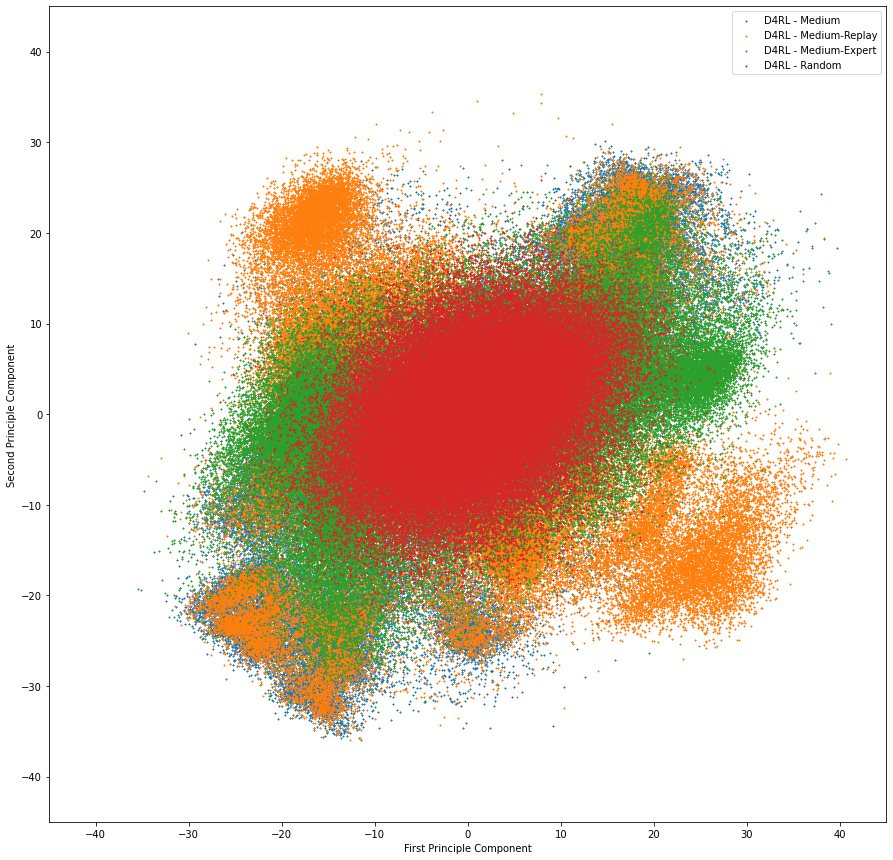

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.scatter(d4rl_m_trans[:,0], d4rl_m_trans[:,1], marker='x', s=1, label='D4RL - Medium')
ax.scatter(d4rl_me_trans[:,0], d4rl_me_trans[:,1], marker='x', s=1, label='D4RL - Medium-Replay')
ax.scatter(d4rl_mr_trans[:,0], d4rl_mr_trans[:,1], marker='x', s=1, label='D4RL - Medium-Expert')
ax.scatter(d4rl_r_trans[:,0], d4rl_r_trans[:,1], marker='x', s=1, label='D4RL - Random')

ax.set_xlim(-45, 45)
ax.set_ylim(-45, 45)

ax.set_xlabel('First Principle Component')
ax.set_ylabel('Second Principle Component')

ax.legend()

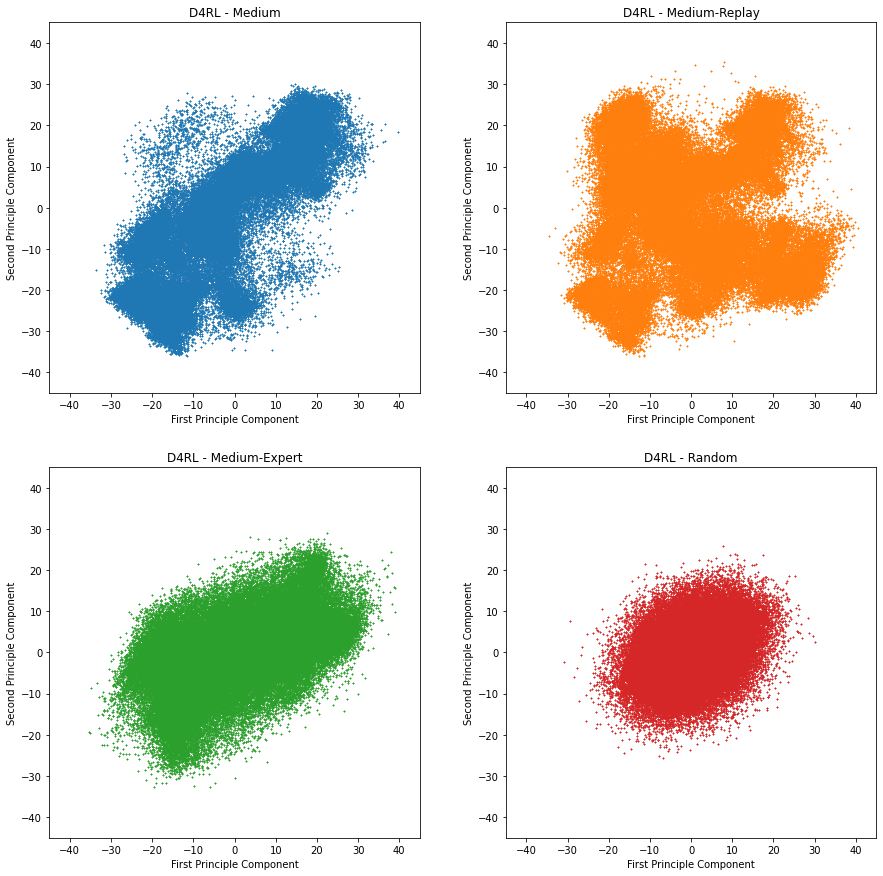

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))

for i, (arr, label) in enumerate([
    (d4rl_m_trans, 'D4RL - Medium'),
    (d4rl_me_trans, 'D4RL - Medium-Replay'),
    (d4rl_mr_trans, 'D4RL - Medium-Expert'),
    (d4rl_r_trans, 'D4RL - Random'),
]):
    ax[i//2, i%2].scatter(arr[:,0], arr[:,1], marker='x', color=cols[i], s=1)
    ax[i//2, i%2].set_xlim(-45, 45)
    ax[i//2, i%2].set_ylim(-45, 45)
    ax[i//2, i%2].set_title(label)
    ax[i//2, i%2].set_xlabel('First Principle Component')
    ax[i//2, i%2].set_ylabel('Second Principle Component')
    ax[i//2, i%2].set_aspect('equal')

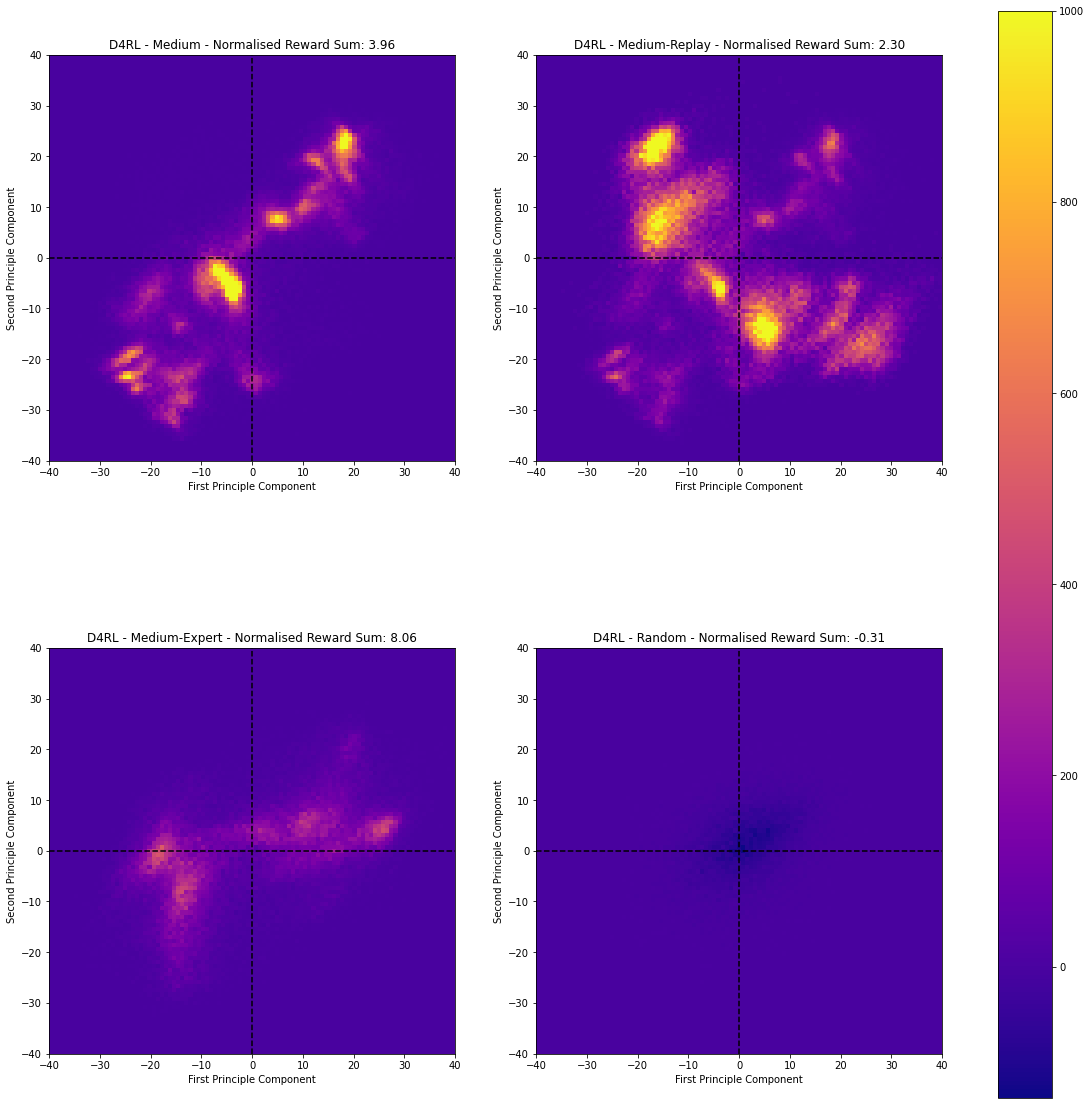

In [18]:
dataset_arrs_labels = [
    (d4rl_m,  d4rl_m_trans, 'D4RL - Medium'),
    (d4rl_mr, d4rl_mr_trans, 'D4RL - Medium-Replay'),
    (d4rl_me, d4rl_me_trans, 'D4RL - Medium-Expert'),
    (d4rl_r, d4rl_r_trans, 'D4RL - Random'),
]
plot_reward_hist2d(dataset_arrs_labels, (2,2), vmax=1000)

# Softlearning

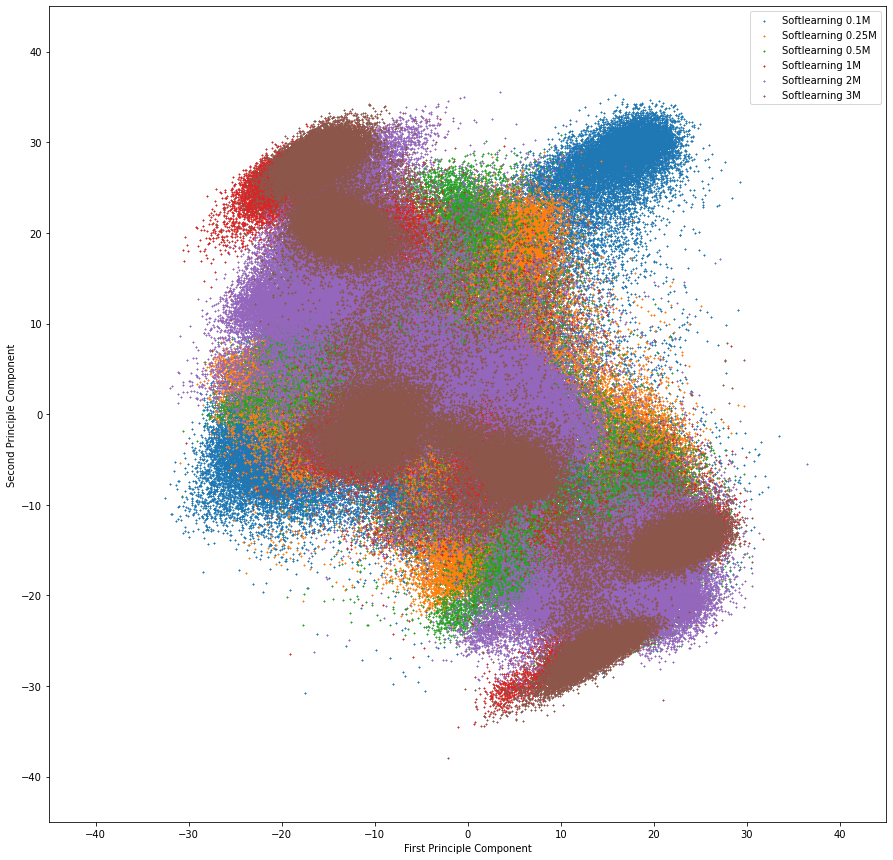

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.scatter(sac_01_m_trans[:,0], sac_01_m_trans[:,1], marker='x', s=1, label='Softlearning 0.1M')
ax.scatter(sac_025_m_trans[:,0], sac_025_m_trans[:,1], marker='x', s=1, label='Softlearning 0.25M')
ax.scatter(sac_05_m_trans[:,0], sac_05_m_trans[:,1], marker='x', s=1, label='Softlearning 0.5M')
ax.scatter(sac_1_m_trans[:,0], sac_1_m_trans[:,1], marker='x', s=1, label='Softlearning 1M')
ax.scatter(sac_2_m_trans[:,0], sac_2_m_trans[:,1], marker='x', s=1, label='Softlearning 2M')
ax.scatter(sac_3_m_trans[:,0], sac_3_m_trans[:,1], marker='x', s=1, label='Softlearning 3M')

ax.set_xlim(-45, 45)
ax.set_ylim(-45, 45)

ax.set_xlabel('First Principle Component')
ax.set_ylabel('Second Principle Component')

ax.legend()

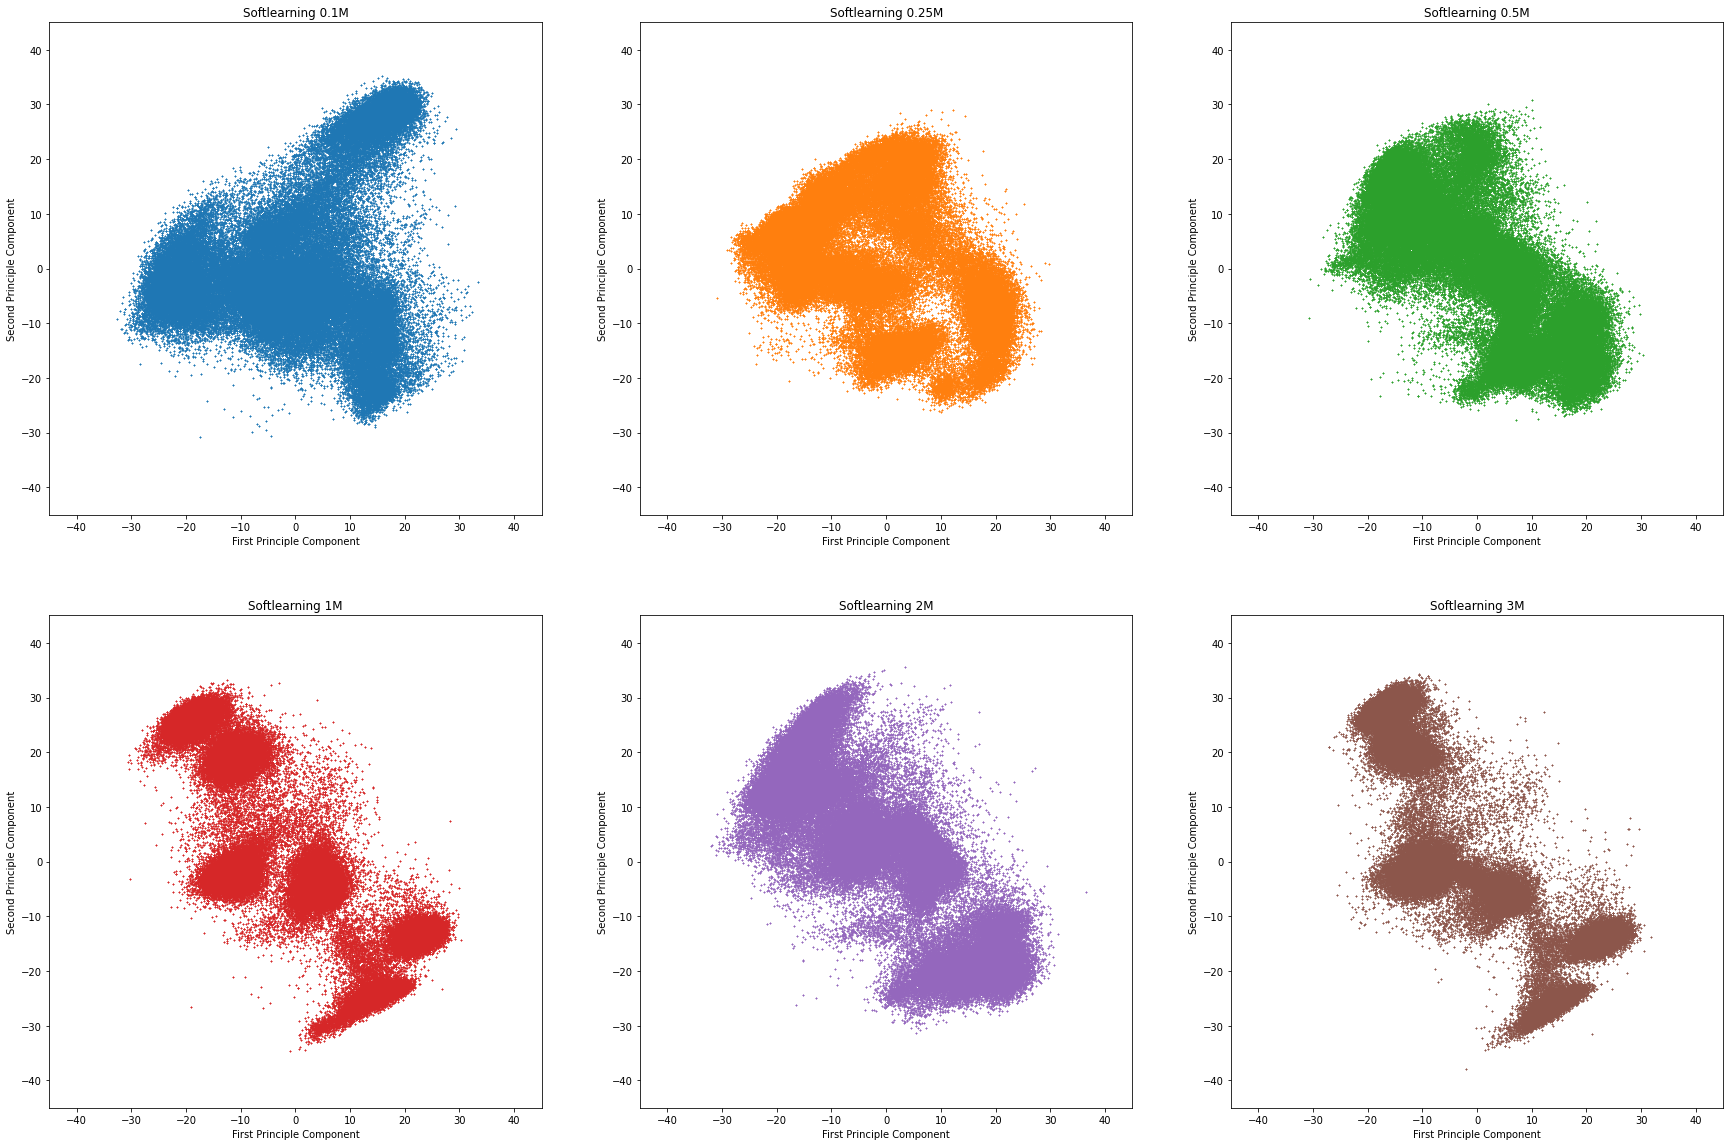

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(30,20))

for i, (arr, label) in enumerate([
    (sac_01_m_trans, 'Softlearning 0.1M'),
    (sac_025_m_trans, 'Softlearning 0.25M'),
    (sac_05_m_trans, 'Softlearning 0.5M'),
    (sac_1_m_trans, 'Softlearning 1M'),
    (sac_2_m_trans, 'Softlearning 2M'),
    (sac_3_m_trans, 'Softlearning 3M'),
]):
    ax[i//3, i%3].scatter(arr[:,0], arr[:,1], marker='x', color=cols[i], s=1)
    ax[i//3, i%3].set_xlim(-45, 45)
    ax[i//3, i%3].set_ylim(-45, 45)
    ax[i//3, i%3].set_title(label)
    ax[i//3, i%3].set_xlabel('First Principle Component')
    ax[i//3, i%3].set_ylabel('Second Principle Component')
    ax[i//3, i%3].set_aspect('equal')

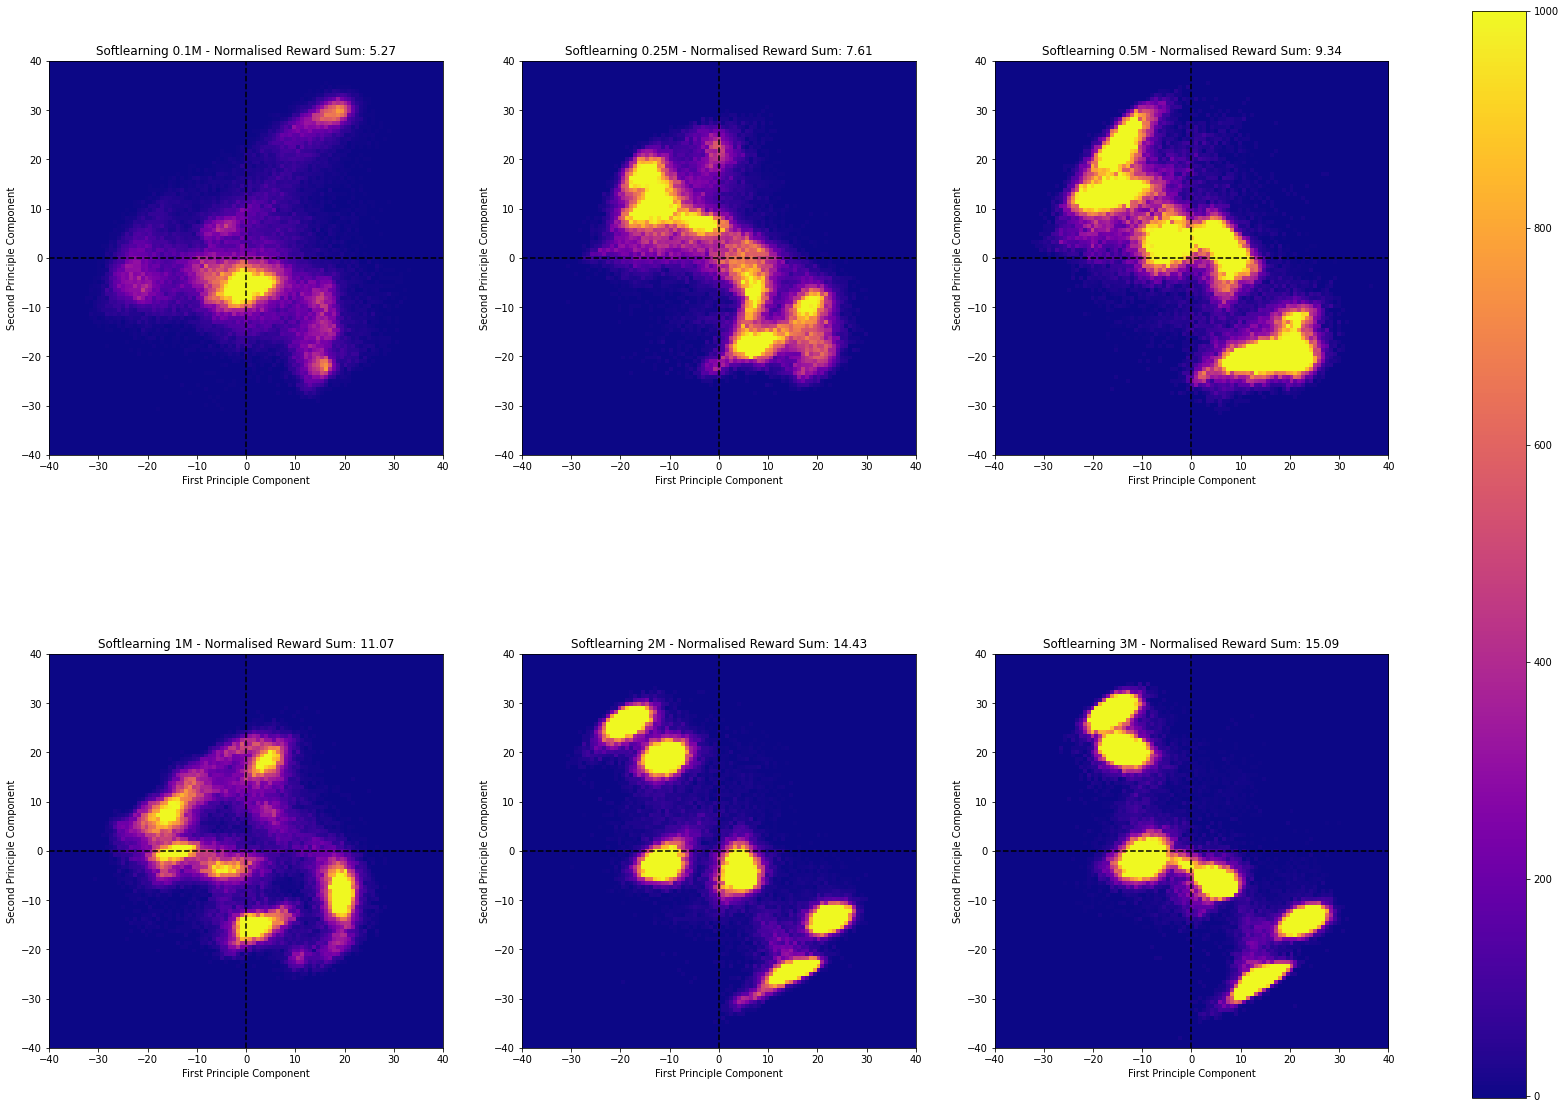

In [21]:
dataset_arrs_labels = [
    (sac_01_m, sac_01_m_trans, 'Softlearning 0.1M'),
    (sac_025_m, sac_025_m_trans, 'Softlearning 0.25M'),
    (sac_05_m, sac_05_m_trans, 'Softlearning 0.5M'),
    (sac_1_m, sac_1_m_trans, 'Softlearning 1M'),
    (sac_2_m, sac_2_m_trans, 'Softlearning 2M'),
    (sac_3_m, sac_3_m_trans, 'Softlearning 3M'),
]
plot_reward_hist2d(dataset_arrs_labels, (2,3), vmax=1000)

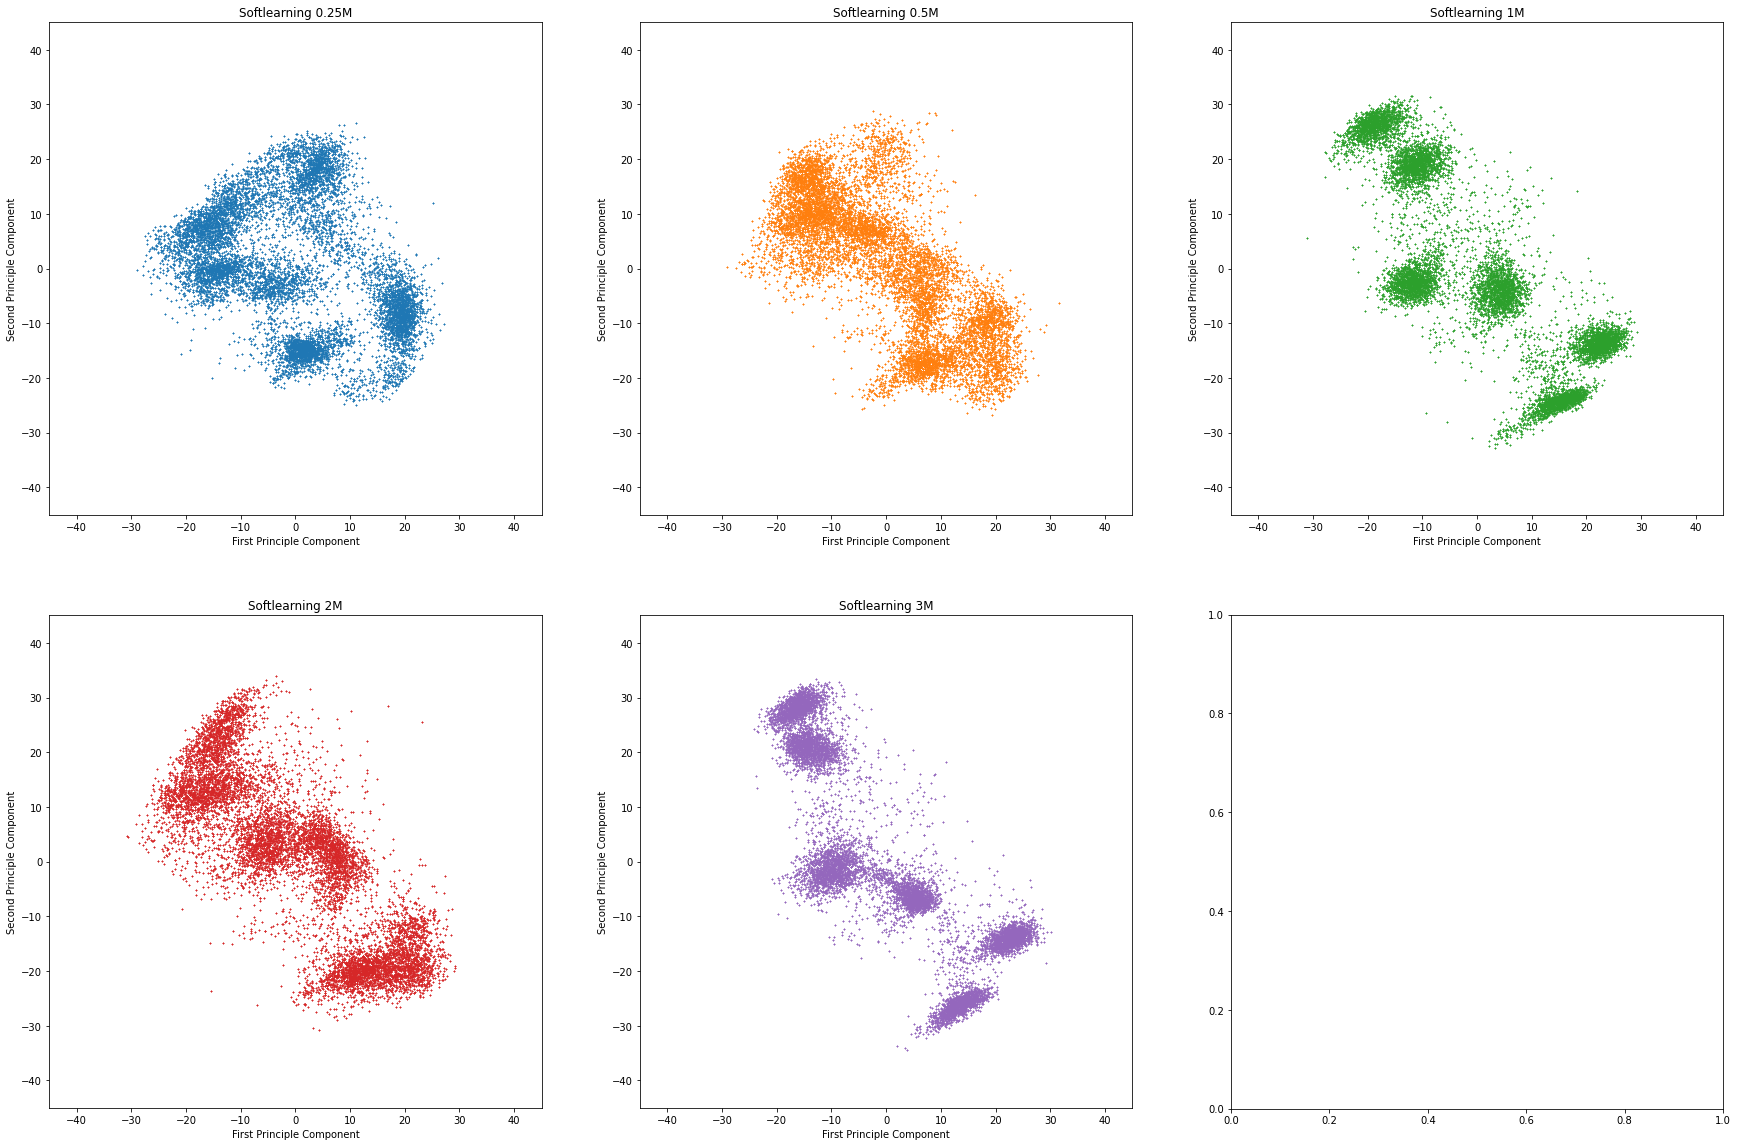

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(30,20))

for i, (arr, label) in enumerate([
    # (sac_01_m_4_trans, 'Softlearning 0.1M'),
    (sac_025_m_4_trans, 'Softlearning 0.25M'),
    (sac_05_m_4_trans, 'Softlearning 0.5M'),
    (sac_1_m_4_trans, 'Softlearning 1M'),
    (sac_2_m_4_trans, 'Softlearning 2M'),
    (sac_3_m_4_trans, 'Softlearning 3M'),
]):
    ax[i//3, i%3].scatter(arr[:,0], arr[:,1], marker='x', color=cols[i], s=1)
    ax[i//3, i%3].set_xlim(-45, 45)
    ax[i//3, i%3].set_ylim(-45, 45)
    ax[i//3, i%3].set_title(label)
    ax[i//3, i%3].set_xlabel('First Principle Component')
    ax[i//3, i%3].set_ylabel('Second Principle Component')
    ax[i//3, i%3].set_aspect('equal')

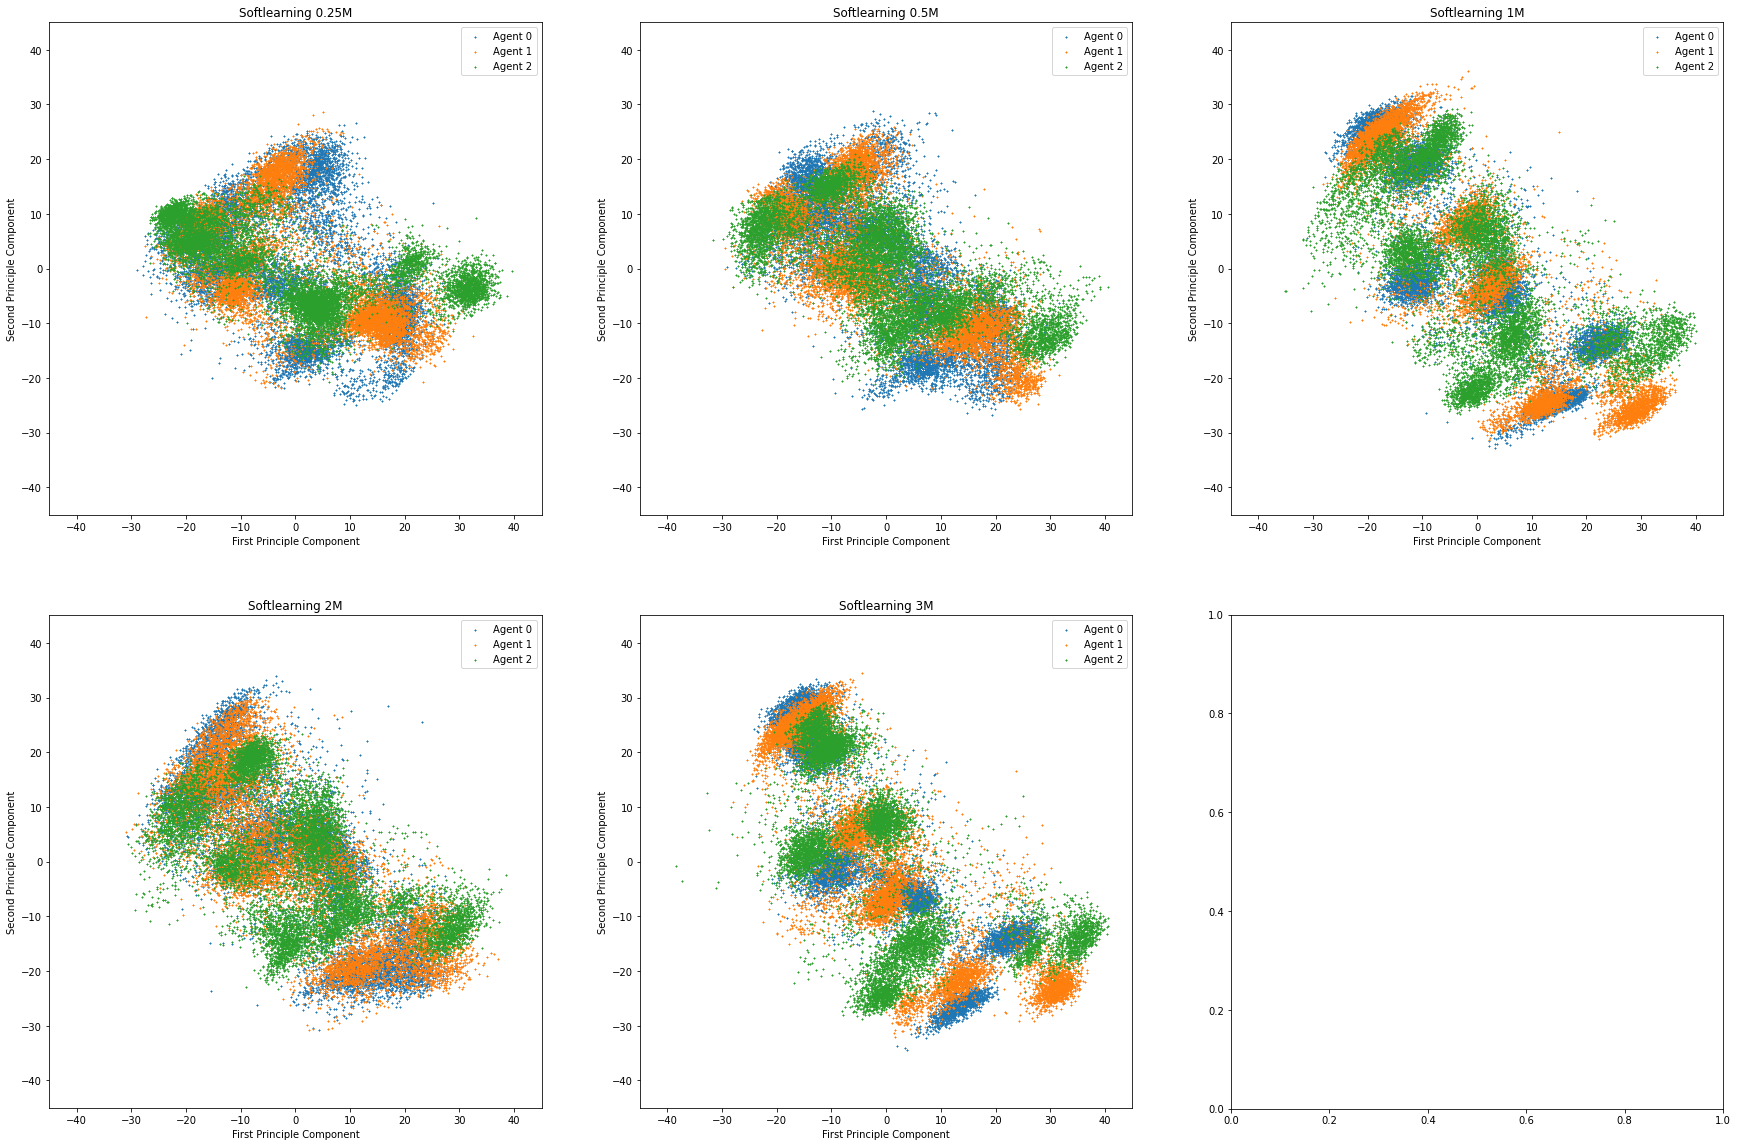

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(30,20))

for i, (arrs, label) in enumerate([
    # ((sac_01_m_trans, None, None), 'Softlearning 0.1M'),
    ((sac_025_m_4_trans, sac_025_m_2_trans, sac_025_m_3_trans), 'Softlearning 0.25M'),
    ((sac_05_m_4_trans, sac_05_m_2_trans, sac_05_m_3_trans), 'Softlearning 0.5M'),
    ((sac_1_m_4_trans, sac_1_m_2_trans, sac_1_m_3_trans), 'Softlearning 1M'),
    ((sac_2_m_4_trans, sac_2_m_2_trans, sac_2_m_3_trans), 'Softlearning 2M'),
    ((sac_3_m_4_trans, sac_3_m_2_trans, sac_3_m_3_trans), 'Softlearning 3M'),
]):
    for j, arr in enumerate(arrs):
        ax[i//3, i%3].scatter(arr[:,0], arr[:,1], marker='x', color=cols[j], s=1, label=f'Agent {j}')
        ax[i//3, i%3].set_xlim(-45, 45)
        ax[i//3, i%3].set_ylim(-45, 45)
        ax[i//3, i%3].set_title(label)
        ax[i//3, i%3].set_xlabel('First Principle Component')
        ax[i//3, i%3].set_ylabel('Second Principle Component')
        ax[i//3, i%3].set_aspect('equal')
    ax[i//3, i%3].legend()

# D3RLPY

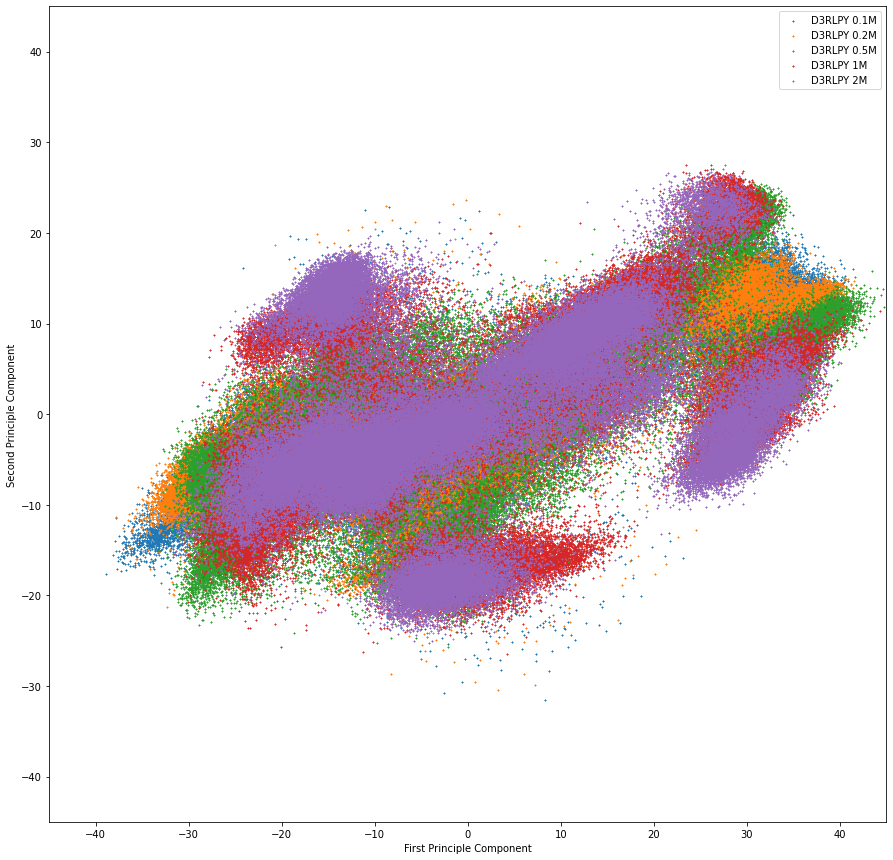

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.scatter(d3rlpy_01_trans[:,0], d3rlpy_01_trans[:,1], marker='x', s=1, label='D3RLPY 0.1M')
ax.scatter(d3rlpy_02_trans[:,0], d3rlpy_02_trans[:,1], marker='x', s=1, label='D3RLPY 0.2M')
ax.scatter(d3rlpy_05_trans[:,0], d3rlpy_05_trans[:,1], marker='x', s=1, label='D3RLPY 0.5M')
ax.scatter(d3rlpy_1_trans[:,0], d3rlpy_1_trans[:,1], marker='x', s=1, label='D3RLPY 1M')
ax.scatter(d3rlpy_2_trans[:,0], d3rlpy_2_trans[:,1], marker='x', s=1, label='D3RLPY 2M')

ax.set_xlim(-45, 45)
ax.set_ylim(-45, 45)

ax.set_xlabel('First Principle Component')
ax.set_ylabel('Second Principle Component')

ax.legend()

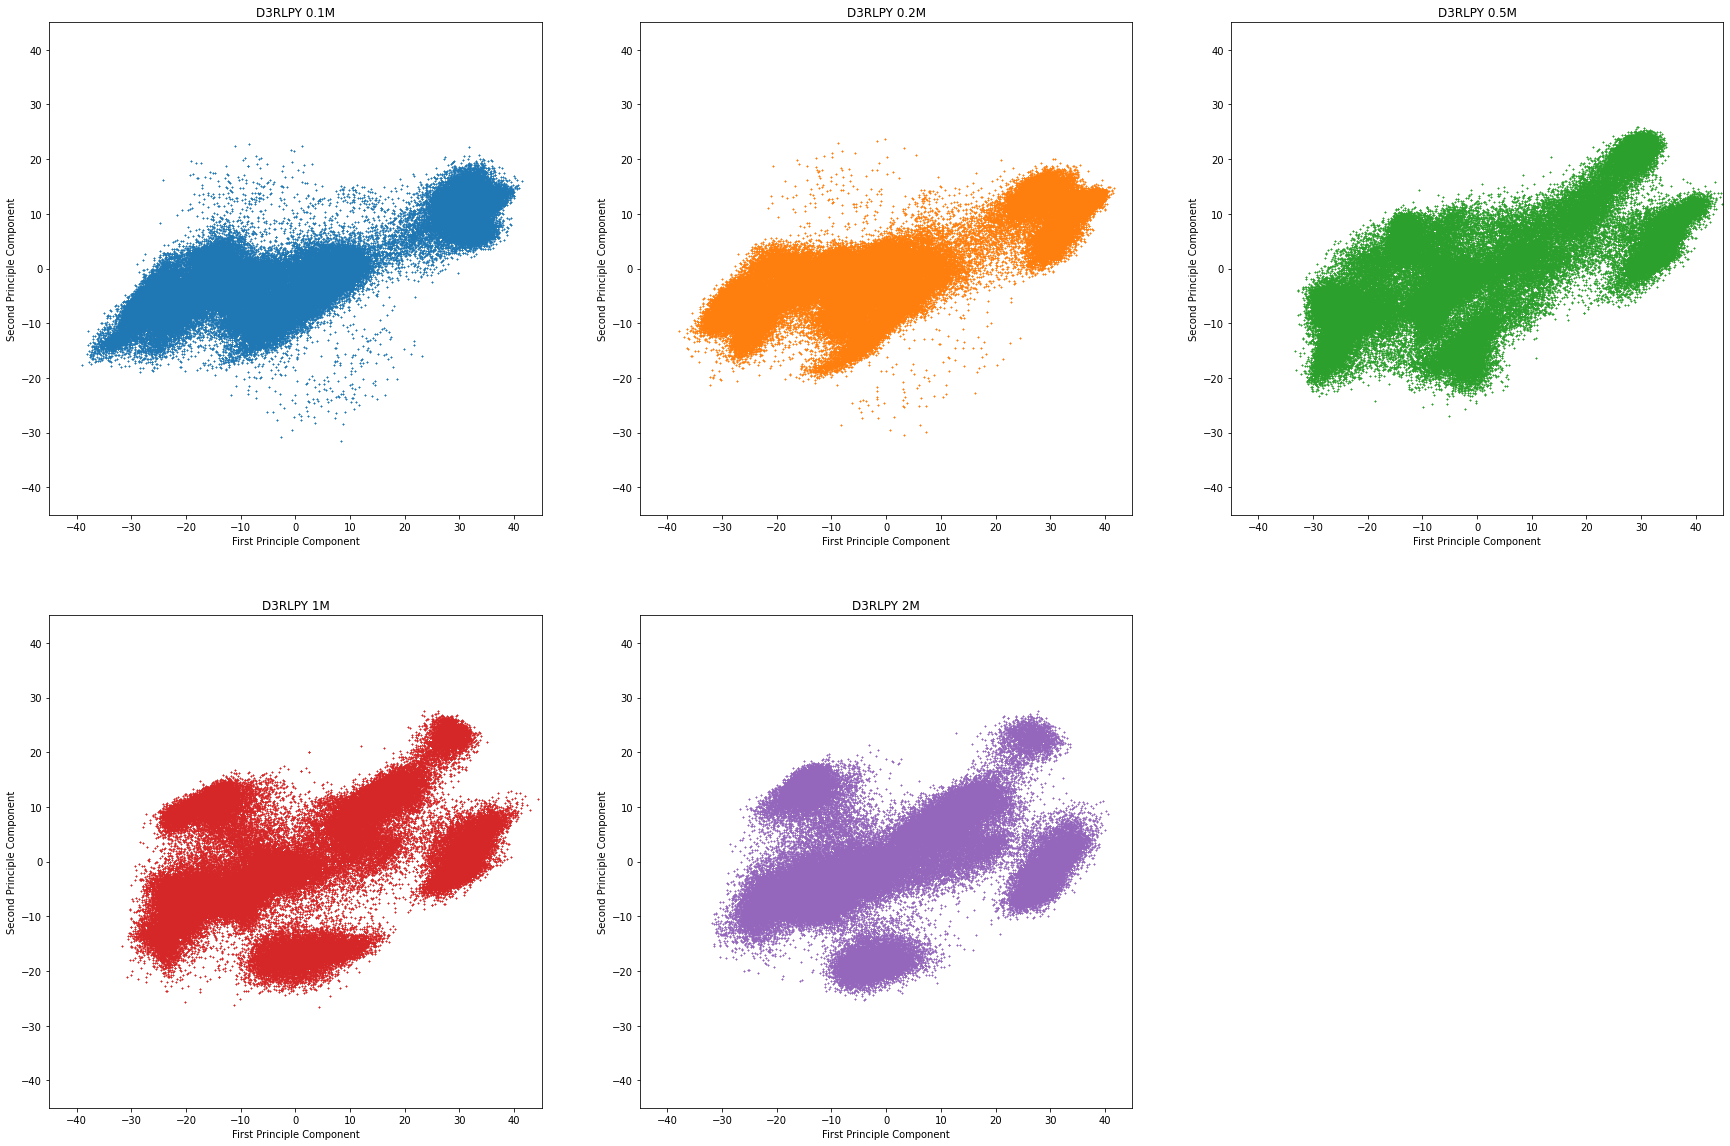

In [25]:
fig, ax = plt.subplots(2, 3, figsize=(30,20))

for i, (arr, label) in enumerate([
    (d3rlpy_01_trans, 'D3RLPY 0.1M'),
    (d3rlpy_02_trans, 'D3RLPY 0.2M'),
    (d3rlpy_05_trans, 'D3RLPY 0.5M'),
    (d3rlpy_1_trans, 'D3RLPY 1M'),
    (d3rlpy_2_trans, 'D3RLPY 2M'),
    (None, None),
]):
    if arr is None:
        fig.delaxes(ax[i%2, i//2])
        continue
    ax[i//3, i%3].scatter(arr[:,0], arr[:,1], marker='x', color=cols[i], s=1)
    ax[i//3, i%3].set_xlim(-45, 45)
    ax[i//3, i%3].set_ylim(-45, 45)
    ax[i//3, i%3].set_title(label)
    ax[i//3, i%3].set_xlabel('First Principle Component')
    ax[i//3, i%3].set_ylabel('Second Principle Component')
    ax[i//3, i%3].set_aspect('equal')

# ax[1,0].set_position([0.125,0.63,0.25,0.25])
# ax[1,1].set_position([0.125,0.63,0.25,0.25])

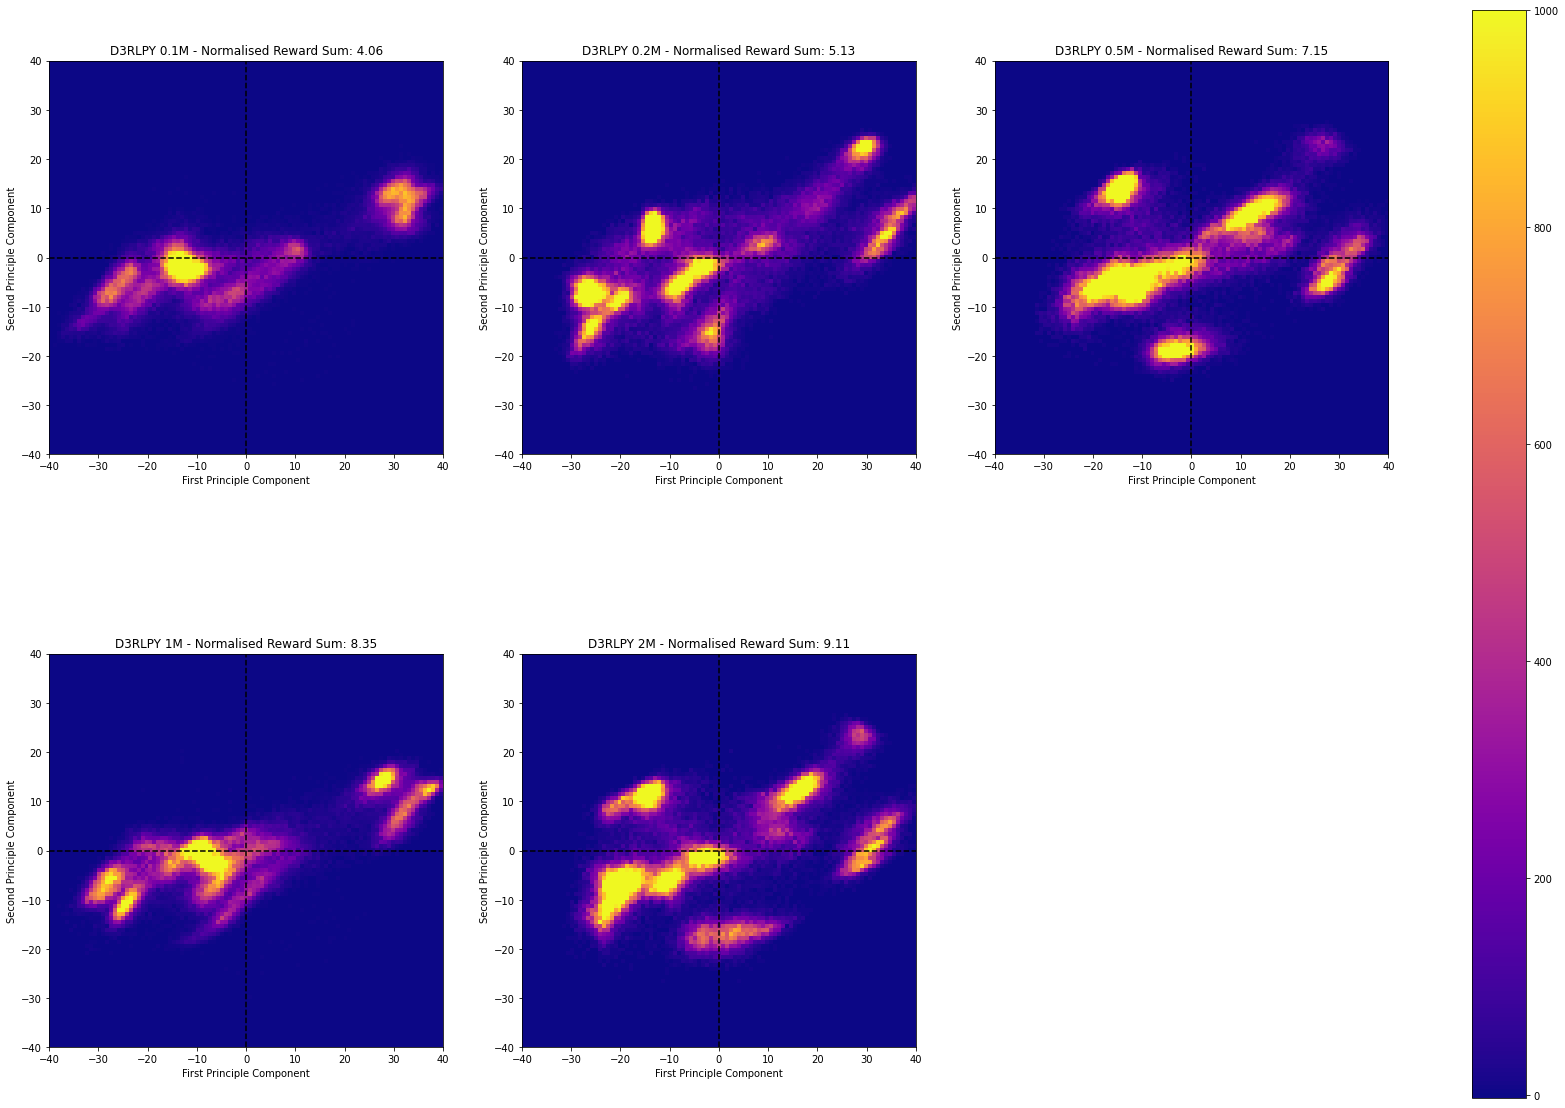

In [26]:
dataset_arrs_labels = [
    (d3rlpy_01, d3rlpy_01_trans, 'D3RLPY 0.1M'),
    (d3rlpy_02, d3rlpy_02_trans, 'D3RLPY 0.2M'),
    (d3rlpy_05, d3rlpy_05_trans, 'D3RLPY 0.5M'),
    (d3rlpy_1, d3rlpy_1_trans, 'D3RLPY 1M'),
    (d3rlpy_2, d3rlpy_2_trans, 'D3RLPY 2M'),
    (None, None, None),
]
plot_reward_hist2d(dataset_arrs_labels, (2,3), vmax=1000)

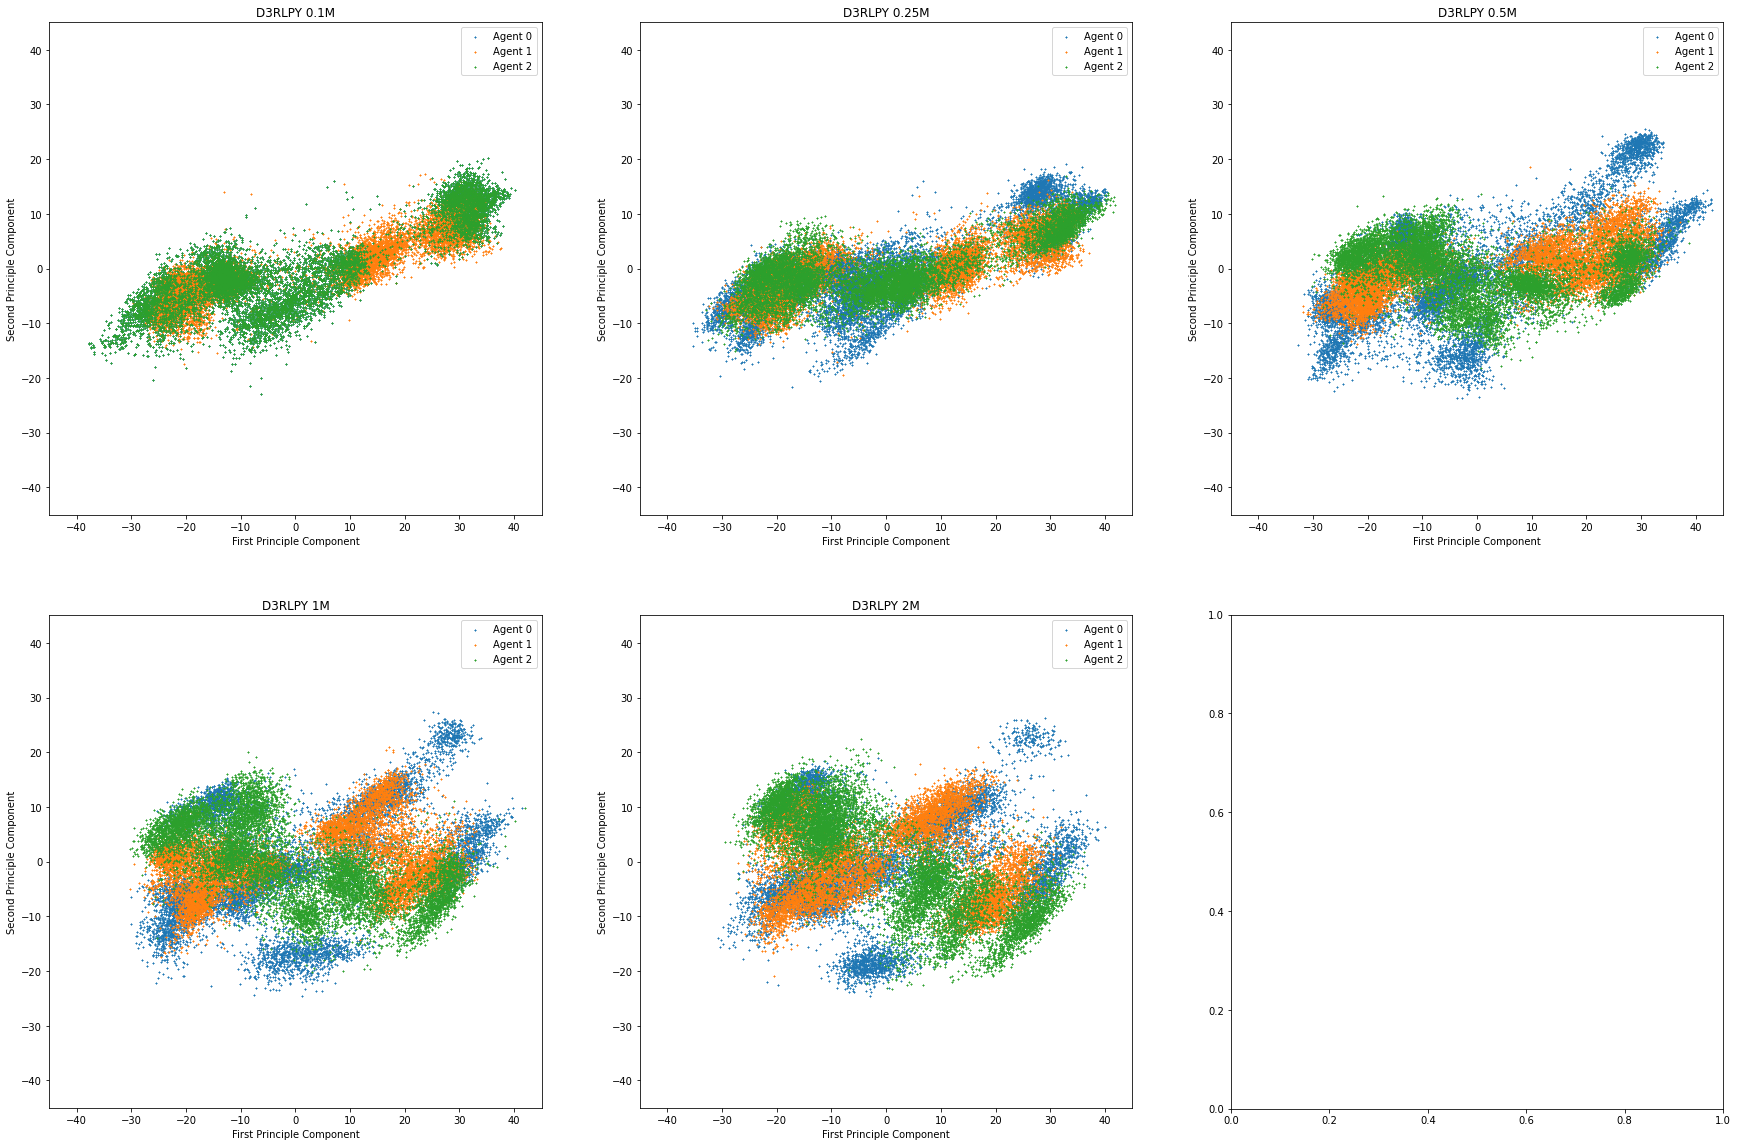

In [27]:
fig, ax = plt.subplots(2, 3, figsize=(30,20))

for i, (arrs, label) in enumerate([
    ((d3rlpy_01_4_trans, d3rlpy_01_2_trans, d3rlpy_01_4_trans), 'D3RLPY 0.1M'),
    ((d3rlpy_02_4_trans, d3rlpy_02_2_trans, d3rlpy_02_3_trans), 'D3RLPY 0.25M'),
    ((d3rlpy_05_4_trans, d3rlpy_05_2_trans, d3rlpy_05_3_trans), 'D3RLPY 0.5M'),
    ((d3rlpy_1_4_trans, d3rlpy_1_2_trans, d3rlpy_1_3_trans), 'D3RLPY 1M'),
    ((d3rlpy_2_4_trans, d3rlpy_2_2_trans, d3rlpy_2_3_trans), 'D3RLPY 2M'),
]):
    for j, arr in enumerate(arrs):
        ax[i//3, i%3].scatter(arr[:,0], arr[:,1], marker='x', color=cols[j], s=1, label=f'Agent {j}')
        ax[i//3, i%3].set_xlim(-45, 45)
        ax[i//3, i%3].set_ylim(-45, 45)
        ax[i//3, i%3].set_title(label)
        ax[i//3, i%3].set_xlabel('First Principle Component')
        ax[i//3, i%3].set_ylabel('Second Principle Component')
        ax[i//3, i%3].set_aspect('equal')
    ax[i//3, i%3].legend()

# MP4 and PAP8 Datasets

In [20]:
mp4_0 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-MP4-P0_25000.npy'))[:,:TARGET_DIMS])
mp4_1 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-MP4-P1_25000.npy'))[:,:TARGET_DIMS])
mp4_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-MP4-P2_25000.npy'))[:,:TARGET_DIMS])
mp4_3 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-MP4-P3_25000.npy'))[:,:TARGET_DIMS])
mp4_4 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-MP4-P4_25000.npy'))[:,:TARGET_DIMS])

pap8_0 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-PAP8-P0_25000.npy'))[:,:TARGET_DIMS])
pap8_1 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-PAP8-P1_25000.npy'))[:,:TARGET_DIMS])
pap8_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-PAP8-P2_25000.npy'))[:,:TARGET_DIMS])
pap8_3 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-PAP8-P3_25000.npy'))[:,:TARGET_DIMS])
pap8_4 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-PAP8-P4_25000.npy'))[:,:TARGET_DIMS])

mp4_0_trans = pca.transform(mp4_0)
mp4_1_trans = pca.transform(mp4_1)
mp4_2_trans = pca.transform(mp4_2)
mp4_3_trans = pca.transform(mp4_3)
mp4_4_trans = pca.transform(mp4_4)

pap8_0_trans = pca.transform(pap8_0)
pap8_1_trans = pca.transform(pap8_1)
pap8_2_trans = pca.transform(pap8_2)
pap8_3_trans = pca.transform(pap8_3)
pap8_4_trans = pca.transform(pap8_4)

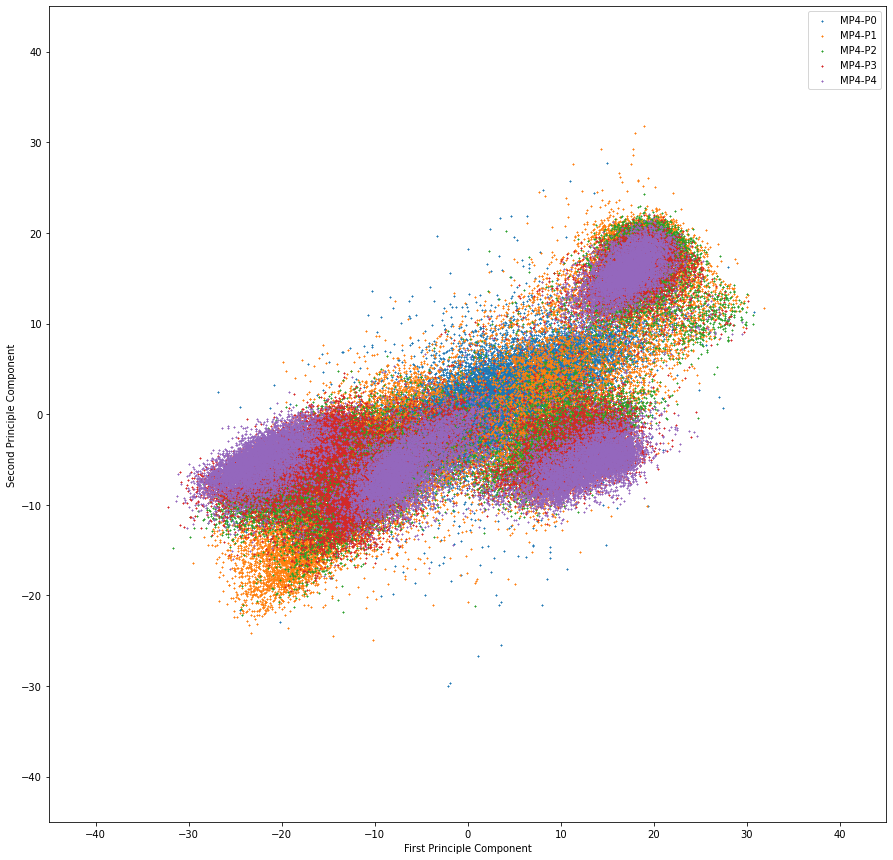

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.scatter(mp4_0_trans[:,0], mp4_0_trans[:,1], marker='x', s=1, label='MP4-P0')
ax.scatter(mp4_1_trans[:,0], mp4_1_trans[:,1], marker='x', s=1, label='MP4-P1')
ax.scatter(mp4_2_trans[:,0], mp4_2_trans[:,1], marker='x', s=1, label='MP4-P2')
ax.scatter(mp4_3_trans[:,0], mp4_3_trans[:,1], marker='x', s=1, label='MP4-P3')
ax.scatter(mp4_4_trans[:,0], mp4_4_trans[:,1], marker='x', s=1, label='MP4-P4')

ax.set_xlim(-45, 45)
ax.set_ylim(-45, 45)

ax.set_xlabel('First Principle Component')
ax.set_ylabel('Second Principle Component')

ax.legend()

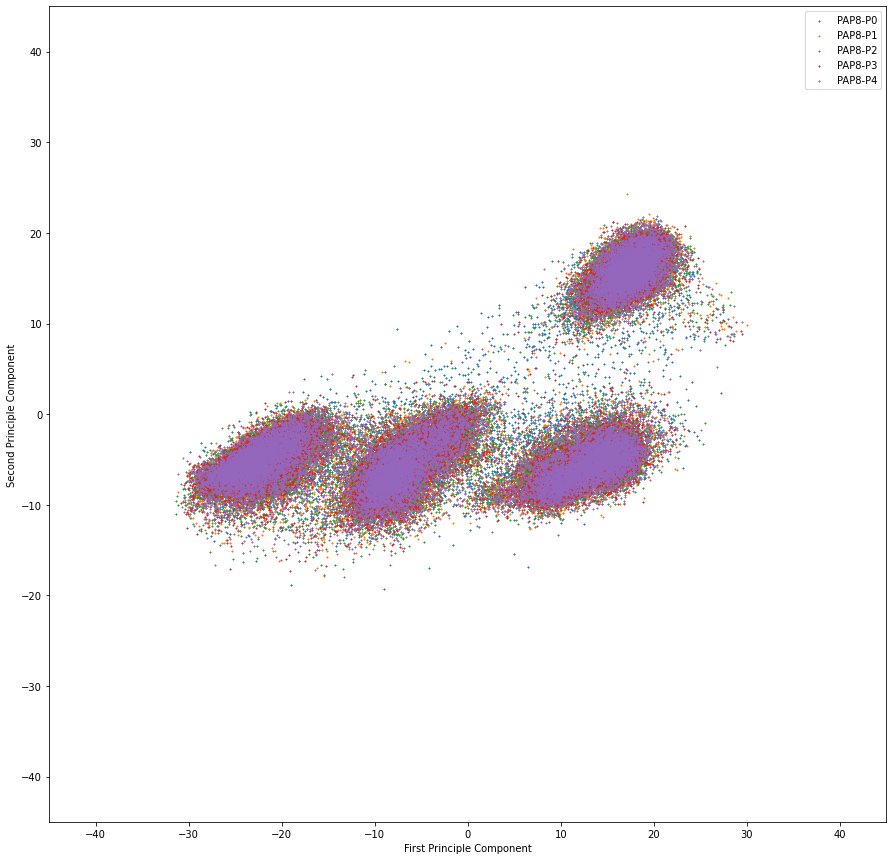

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.scatter(pap8_0_trans[:,0], pap8_0_trans[:,1], marker='x', s=1, label='PAP8-P0')
ax.scatter(pap8_1_trans[:,0], pap8_1_trans[:,1], marker='x', s=1, label='PAP8-P1')
ax.scatter(pap8_2_trans[:,0], pap8_2_trans[:,1], marker='x', s=1, label='PAP8-P2')
ax.scatter(pap8_3_trans[:,0], pap8_3_trans[:,1], marker='x', s=1, label='PAP8-P3')
ax.scatter(pap8_4_trans[:,0], pap8_4_trans[:,1], marker='x', s=1, label='PAP8-P4')

ax.set_xlim(-45, 45)
ax.set_ylim(-45, 45)

ax.set_xlabel('First Principle Component')
ax.set_ylabel('Second Principle Component')

ax.legend()

# MIXED-1

In [24]:
mixed_1 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'MIXED-1.npy'))[:,:TARGET_DIMS])
rand_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'RAND-2.npy'))[:,:TARGET_DIMS])
rand_9 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'RAND-9.npy'))[:,:TARGET_DIMS])
d3rlpy_mp1_p4 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-MP1-P4_100000.npy'))[:20000,:TARGET_DIMS])
d3rlpy_mp2_p1 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-MP2-P1_100000.npy'))[:20000,:TARGET_DIMS])
d3rlpy_pap6_p0 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-PAP6-P0_100000.npy'))[:20000,:TARGET_DIMS])


In [25]:
mixed_1_trans = pca.transform(mixed_1)
rand_2_trans = pca.transform(rand_2)
rand_9_trans = pca.transform(rand_9)
d3rlpy_mp1_p4_trans = pca.transform(d3rlpy_mp1_p4)
d3rlpy_mp2_p1_trans = pca.transform(d3rlpy_mp2_p1)
d3rlpy_pap6_p0_trans = pca.transform(d3rlpy_pap6_p0)

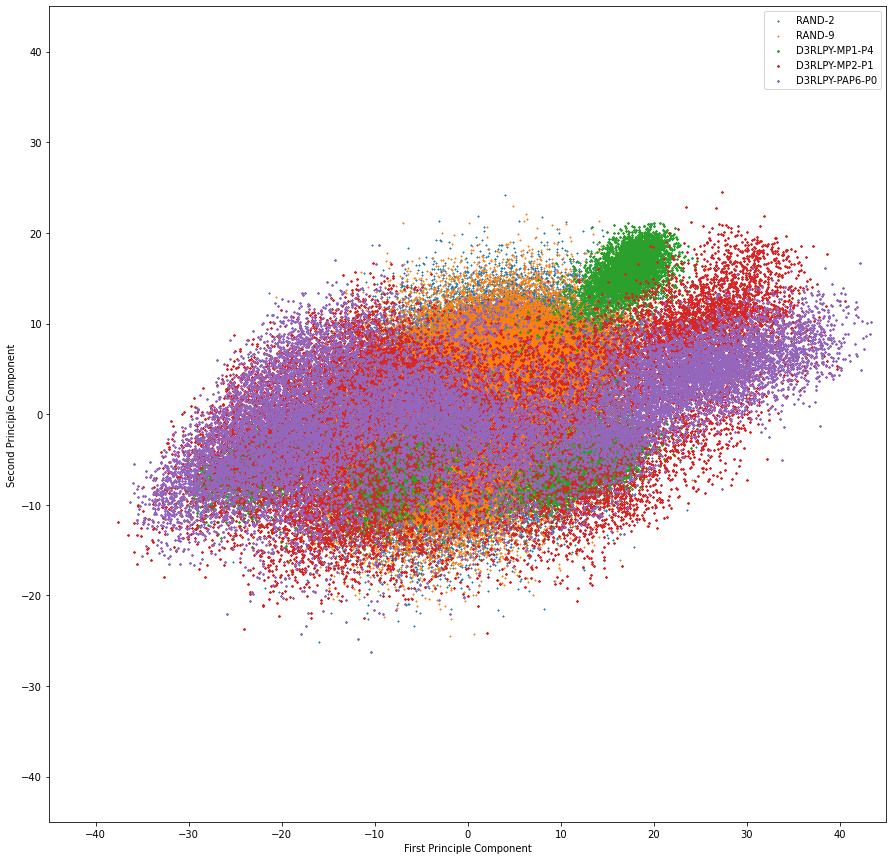

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.scatter(rand_2_trans[:,0], rand_2_trans[:,1], marker='x', s=1, label='RAND-2')
ax.scatter(rand_9_trans[:,0], rand_9_trans[:,1], marker='x', s=1, label='RAND-9')
ax.scatter(d3rlpy_mp1_p4_trans[:,0], d3rlpy_mp1_p4_trans[:,1], marker='x', s=3, label='D3RLPY-MP1-P4')
ax.scatter(d3rlpy_mp2_p1_trans[:,0], d3rlpy_mp2_p1_trans[:,1], marker='x', s=3, label='D3RLPY-MP2-P1')
ax.scatter(d3rlpy_pap6_p0_trans[:,0], d3rlpy_pap6_p0_trans[:,1], marker='x', s=3, label='D3RLPY-PAP6-P0')

ax.set_xlim(-45, 45)
ax.set_ylim(-45, 45)

ax.set_xlabel('First Principle Component')
ax.set_ylabel('Second Principle Component')

ax.legend()

# MIXED-2

In [27]:
mixed_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'MIXED-2.npy'))[:,:TARGET_DIMS])
d3rlpy_mp2_p2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-MP2-P2_100000.npy'))[:20000,:TARGET_DIMS])
d3rlpy_mp3_p0 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-MP3-P0_100000.npy'))[:20000,:TARGET_DIMS])
d3rlpy_pap5_p0 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-PAP5-P0_100000.npy'))[:20000,:TARGET_DIMS])
d3rlpy_pap6_p4 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-PAP6-P4_100000.npy'))[:20000,:TARGET_DIMS])
d3rlpy_pap7_p0 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-PAP7-P0_100000.npy'))[:20000,:TARGET_DIMS])


In [28]:
mixed_2 = pca.transform(mixed_2)
d3rlpy_mp2_p2 = pca.transform(d3rlpy_mp2_p2)
d3rlpy_mp3_p0 = pca.transform(d3rlpy_mp3_p0)
d3rlpy_pap5_p0 = pca.transform(d3rlpy_pap5_p0)
d3rlpy_pap6_p4 = pca.transform(d3rlpy_pap6_p4)
d3rlpy_pap7_p0 = pca.transform(d3rlpy_pap7_p0)

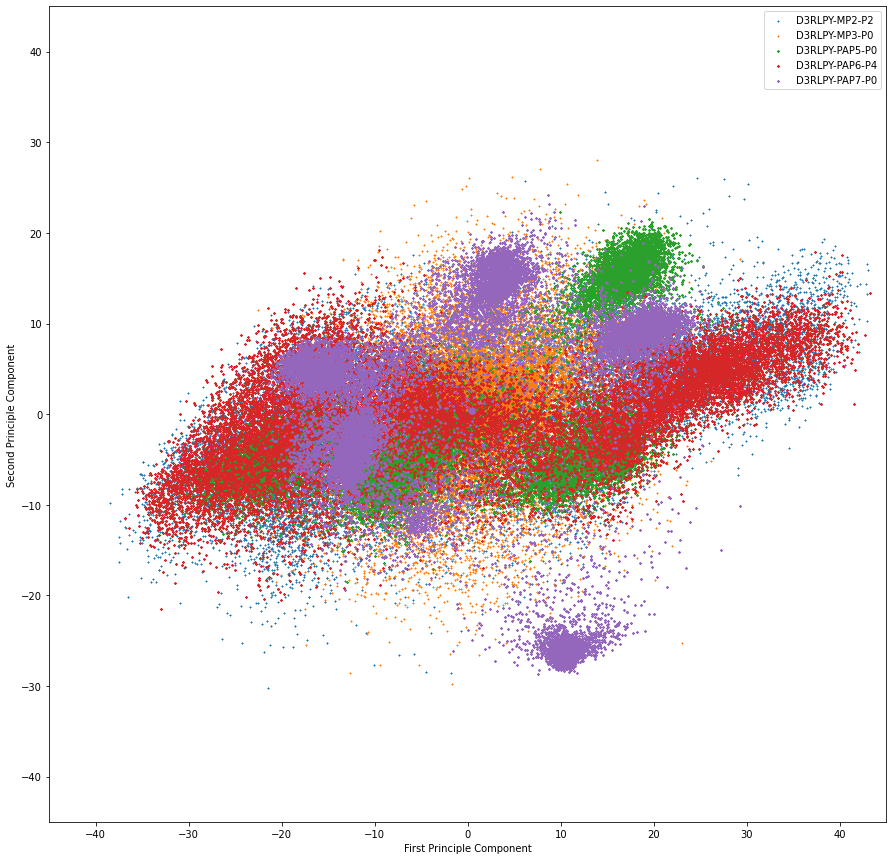

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.scatter(d3rlpy_mp2_p2[:,0], d3rlpy_mp2_p2[:,1], marker='x', s=1, label='D3RLPY-MP2-P2')
ax.scatter(d3rlpy_mp3_p0[:,0], d3rlpy_mp3_p0[:,1], marker='x', s=1, label='D3RLPY-MP3-P0')
ax.scatter(d3rlpy_pap5_p0[:,0], d3rlpy_pap5_p0[:,1], marker='x', s=3, label='D3RLPY-PAP5-P0')
ax.scatter(d3rlpy_pap6_p4[:,0], d3rlpy_pap6_p4[:,1], marker='x', s=3, label='D3RLPY-PAP6-P4')
ax.scatter(d3rlpy_pap7_p0[:,0], d3rlpy_pap7_p0[:,1], marker='x', s=3, label='D3RLPY-PAP7-P0')

ax.set_xlim(-45, 45)
ax.set_ylim(-45, 45)

ax.set_xlabel('First Principle Component')
ax.set_ylabel('Second Principle Component')

ax.legend()

# MIXED-3

In [30]:
mixed_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'MIXED-2.npy')))
rand_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'RAND-2.npy'))[:20000,:])
rand_9 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'RAND-9.npy'))[:20000,:])
d3rlpy_mp4_p4 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-MP4-P4_20000.npy'))[:,:])
d3rlpy_mp5_p1 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-MP5-P1_20000.npy'))[:,:])
d3rlpy_pap9_p0 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-PAP9-P0_20000.npy'))[:,:])

In [31]:
mixed_2_trans = pca.transform(mixed_2[:,:TARGET_DIMS])
rand_2_trans = pca.transform(rand_2[:20000,:TARGET_DIMS])
rand_9_trans = pca.transform(rand_9[:20000,:TARGET_DIMS])
d3rlpy_mp4_p4_trans = pca.transform(d3rlpy_mp4_p4[:,:TARGET_DIMS])
d3rlpy_mp5_p1_trans = pca.transform(d3rlpy_mp5_p1[:,:TARGET_DIMS])
d3rlpy_pap9_p0_trans = pca.transform(d3rlpy_pap9_p0[:,:TARGET_DIMS])

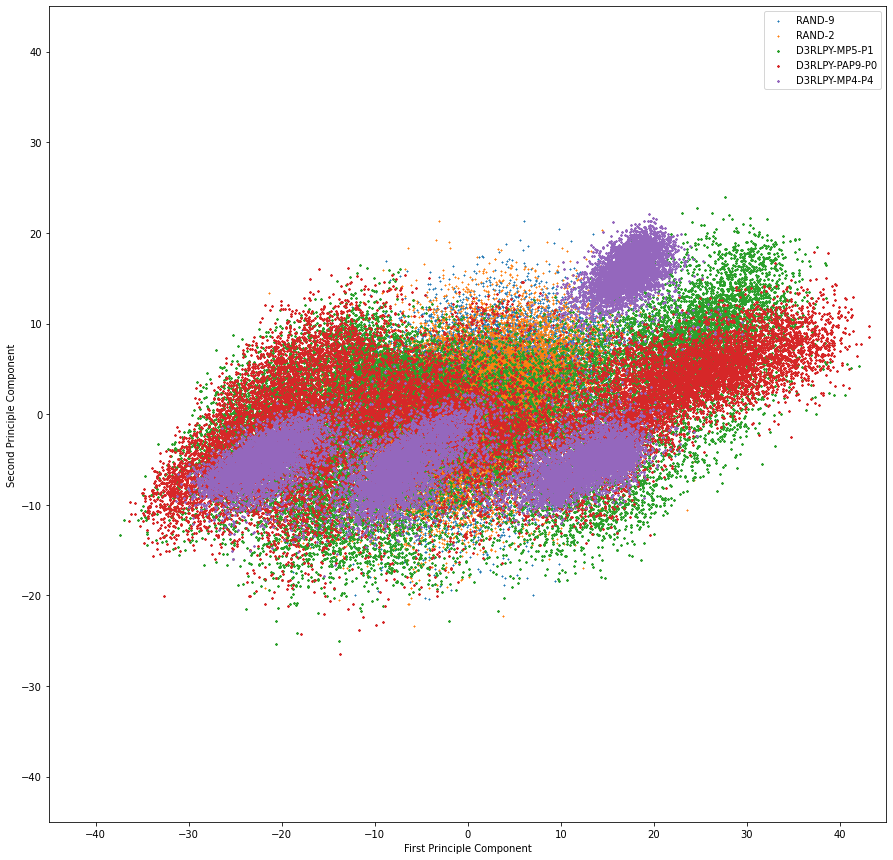

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.scatter(rand_9_trans[:,0], rand_9_trans[:,1], marker='x', s=1, label='RAND-9')
ax.scatter(rand_2_trans[:,0], rand_2_trans[:,1], marker='x', s=1, label='RAND-2')
ax.scatter(d3rlpy_mp5_p1_trans[:,0], d3rlpy_mp5_p1_trans[:,1], marker='x', s=3, label='D3RLPY-MP5-P1')
ax.scatter(d3rlpy_pap9_p0_trans[:,0], d3rlpy_pap9_p0_trans[:,1], marker='x', s=3, label='D3RLPY-PAP9-P0')
ax.scatter(d3rlpy_mp4_p4_trans[:,0], d3rlpy_mp4_p4_trans[:,1], marker='x', s=3, label='D3RLPY-MP4-P4')

ax.set_xlim(-45, 45)
ax.set_ylim(-45, 45)

ax.set_xlabel('First Principle Component')
ax.set_ylabel('Second Principle Component')

ax.legend()

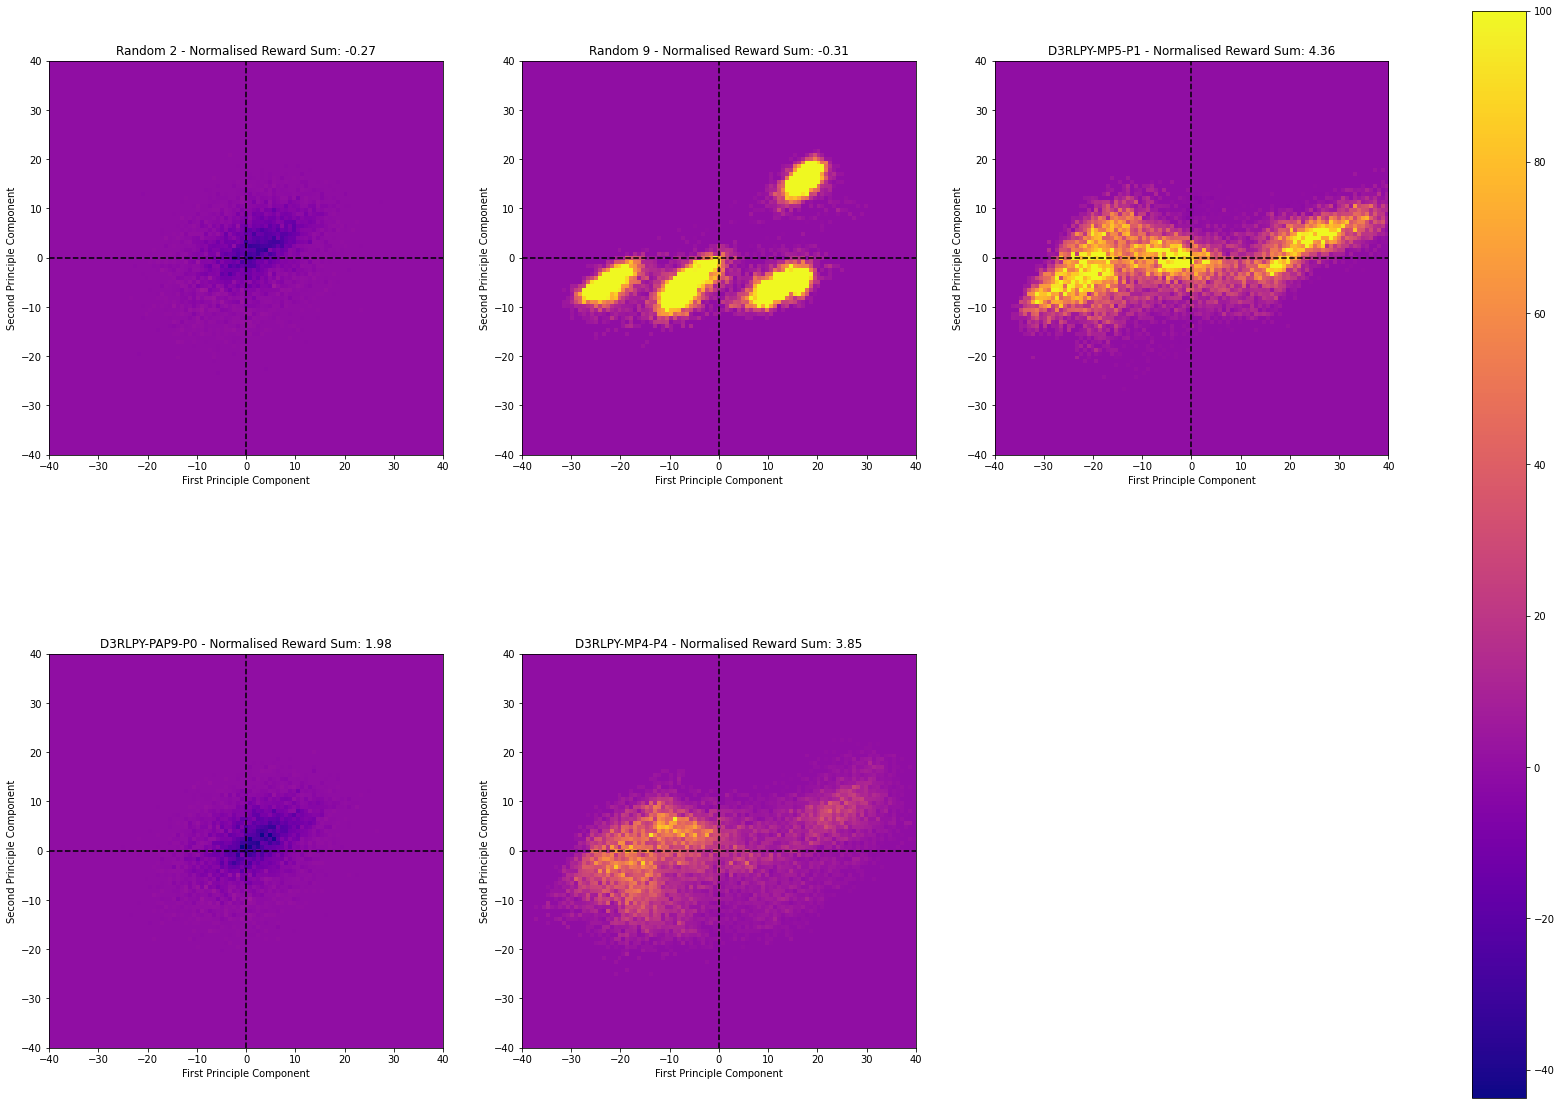

In [33]:
dataset_arrs_labels = [
    (rand_2, rand_2_trans, 'Random 2'),
    (rand_9, rand_9_trans, 'Random 9'),
    (d3rlpy_mp4_p4, d3rlpy_mp4_p4_trans, 'D3RLPY-MP5-P1'),
    (d3rlpy_mp5_p1, d3rlpy_mp5_p1_trans, 'D3RLPY-PAP9-P0'),
    (d3rlpy_pap9_p0, d3rlpy_pap9_p0_trans, 'D3RLPY-MP4-P4'),
    (None, None, None),
]
plot_reward_hist2d(dataset_arrs_labels, (2,3), vmax=100)

# MIXED-RT-1

In [34]:
mixed_rt_1 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'MIXED-RT-1.npy')))
rand_2 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'RAND-2.npy'))[:20000,:])
sac_rt_025m_1_1000 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-0.25M-1-P0_1000000.npy'))[:20000,:])
sac_rt_1m_1_1000 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'SAC-RT-1M-1-P0_1000000.npy'))[:20000,:])
d3rlpy_rt_02m_1_1000 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-0.2M-1-P0_1000000.npy'))[:20000,:])
d3rlpy_rt_2m_1_1000 = constrain_state_angles(np.load(os.path.join(DATA_DIR, 'D3RLPY-RT-2M-1-P0_1000000.npy'))[:20000,:])

In [35]:
mixed_rt_1_trans = pca.transform(mixed_rt_1[:,:TARGET_DIMS])
rand_2_trans = pca.transform(rand_2[:20000,:TARGET_DIMS])
sac_rt_025m_1_1000_trans = pca.transform(sac_rt_025m_1_1000[:20000,:TARGET_DIMS])
sac_rt_1m_1_1000_trans = pca.transform(sac_rt_1m_1_1000[:20000,:TARGET_DIMS])
d3rlpy_rt_02m_1_1000_trans = pca.transform(d3rlpy_rt_02m_1_1000[:20000,:TARGET_DIMS])
d3rlpy_rt_2m_1_1000_trans = pca.transform(d3rlpy_rt_2m_1_1000[:20000,:TARGET_DIMS])

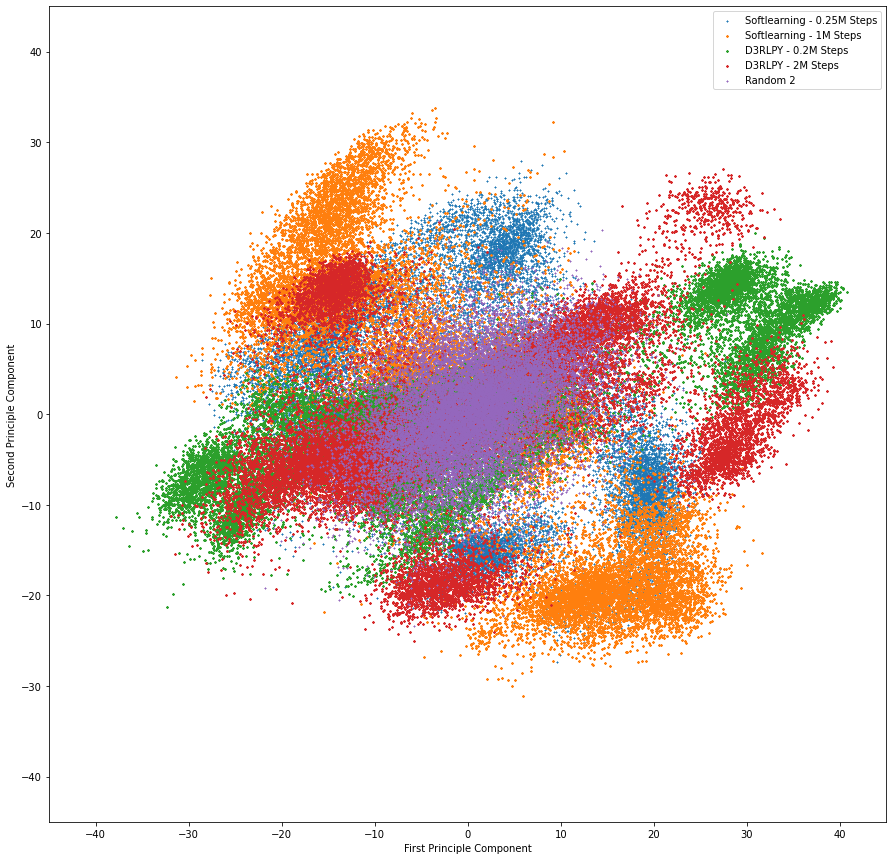

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.scatter(sac_rt_025m_1_1000_trans[:,0], sac_rt_025m_1_1000_trans[:,1], marker='x', s=1, label='Softlearning - 0.25M Steps')
ax.scatter(sac_rt_1m_1_1000_trans[:,0], sac_rt_1m_1_1000_trans[:,1], marker='x', s=3, label='Softlearning - 1M Steps')
ax.scatter(d3rlpy_rt_02m_1_1000_trans[:,0], d3rlpy_rt_02m_1_1000_trans[:,1], marker='x', s=3, label='D3RLPY - 0.2M Steps')
ax.scatter(d3rlpy_rt_2m_1_1000_trans[:,0], d3rlpy_rt_2m_1_1000_trans[:,1], marker='x', s=3, label='D3RLPY - 2M Steps')
ax.scatter(rand_2_trans[:,0], rand_2_trans[:,1], marker='x', s=1, label='Random 2')

ax.set_xlim(-45, 45)
ax.set_ylim(-45, 45)

ax.set_xlabel('First Principle Component')
ax.set_ylabel('Second Principle Component')

ax.legend()

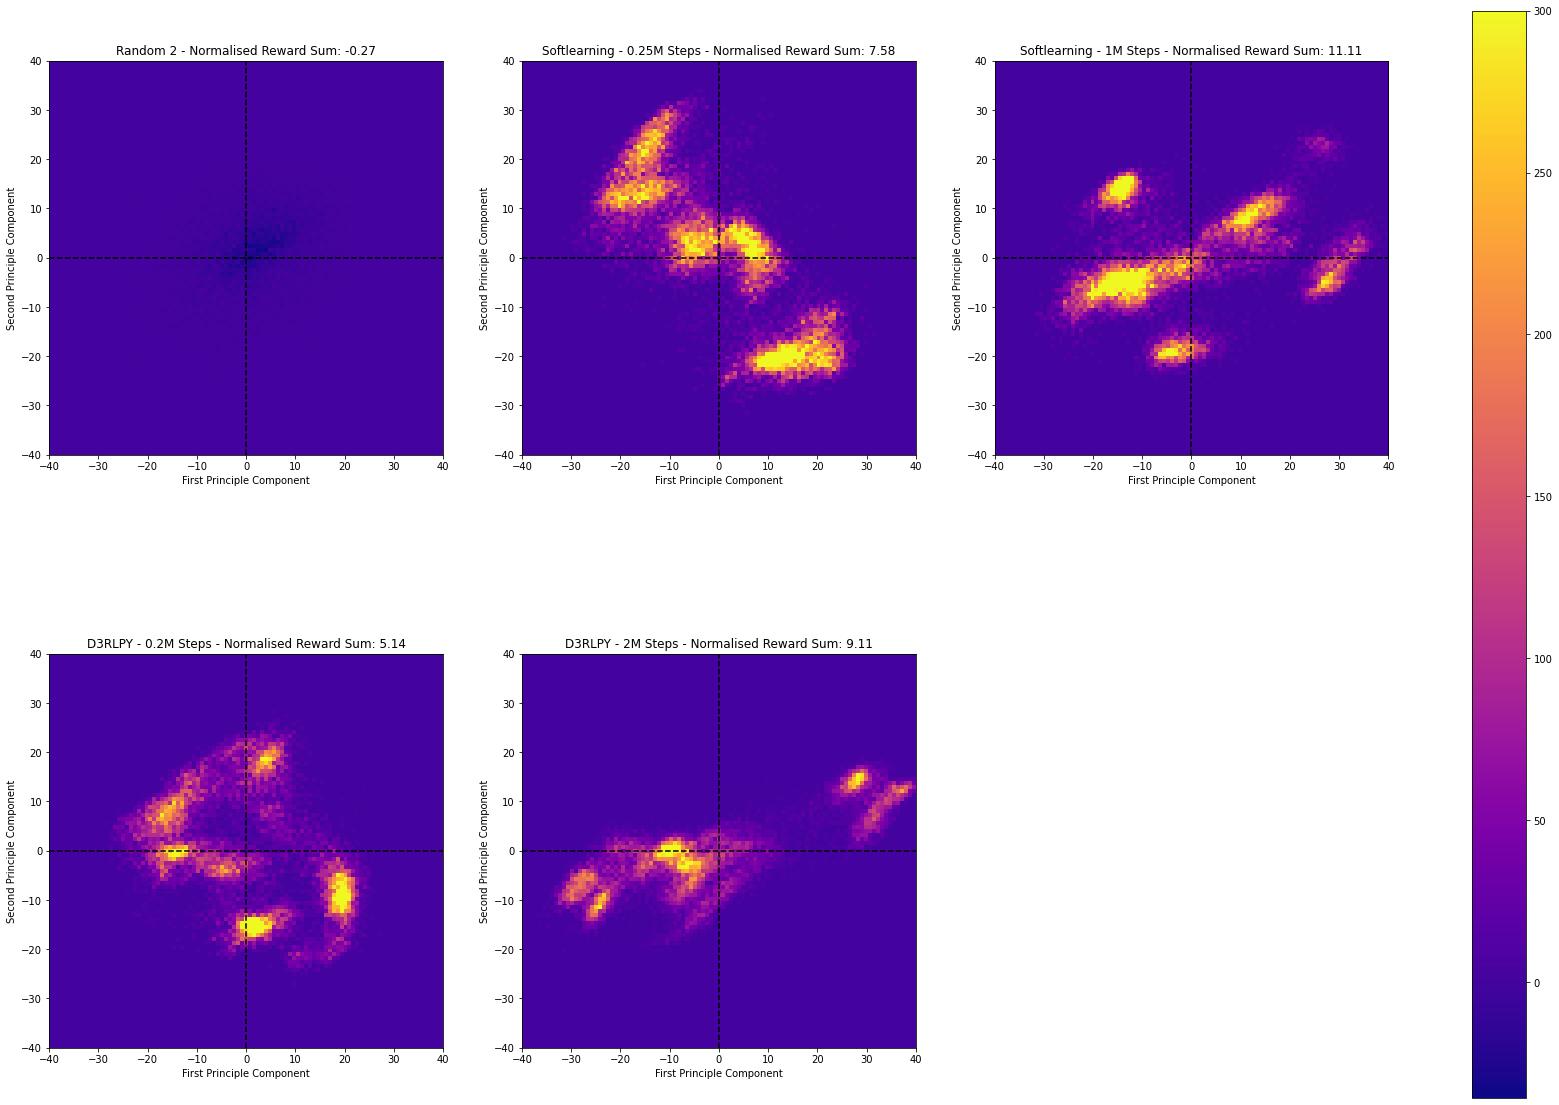

In [37]:
dataset_arrs_labels = [
    (rand_2, rand_2_trans, 'Random 2'),
    (sac_rt_025m_1_1000, sac_rt_025m_1_1000_trans, 'Softlearning - 0.25M Steps'),
    (sac_rt_1m_1_1000, sac_rt_1m_1_1000_trans, 'Softlearning - 1M Steps'),
    (d3rlpy_rt_02m_1_1000, d3rlpy_rt_02m_1_1000_trans, 'D3RLPY - 0.2M Steps'),
    (d3rlpy_rt_2m_1_1000, d3rlpy_rt_2m_1_1000_trans, 'D3RLPY - 2M Steps'),
    (None, None, None),
]
plot_reward_hist2d(dataset_arrs_labels, (2,3), vmax=300)